In [2]:
import os
import pandas as pd # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import LabelEncoder, StandardScaler # type: ignore
from pytorch_tabnet.tab_model import TabNetClassifier # type: ignore
import torch # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import os
import pandas as pd # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import LabelEncoder, StandardScaler # type: ignore
from pytorch_tabnet.tab_model import TabNetClassifier # type: ignore
import torch # type: ignore
import matplotlib.pyplot as plt # type: ignore
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier


In [3]:
import pandas as pd
import glob
import os

FOLDER = "C:/Users/bcccu/Desktop/MQTTIDS/*.csv"

# Load and merge
all_files = glob.glob(FOLDER)
df_list = []
for file in all_files:
    temp_df = pd.read_csv(file)
    temp_df["source_file"] = os.path.basename(file)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

# Print value counts per label
print("Label distribution:\n")
print(df["label"].value_counts())


C:\Users\bcccu\AppData\Local\Temp\ipykernel_28480\1745170715.py:11: DtypeWarning: Columns (362,396,397) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file)
C:\Users\bcccu\AppData\Local\Temp\ipykernel_28480\1745170715.py:11: DtypeWarning: Columns (363,400) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file)
C:\Users\bcccu\AppData\Local\Temp\ipykernel_28480\1745170715.py:11: DtypeWarning: Columns (362,363) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file)
C:\Users\bcccu\AppData\Local\Temp\ipykernel_28480\1745170715.py:11: DtypeWarning: Columns (362,363) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file)
C:\Users\bcccu\AppData\Local\Temp\ipykernel_28480\1745170715.py:11: DtypeWarning: Columns (362,363,396,397) have mixed types. Specify dtype option on import or set low_memory=False

Label distribution:

label
Normal                             720660
Connect-Disconnect-Flood-Attack    332096
encoded-payload-flood-Attack       264936
very-large-message-flood-Attack    165039
Ping-Req-Flood-Attack               73513
unvalid-publish-flood-Attack        57056
publish-subscribe-flood-Attack      56233
valid-publish-flood-Attack          47476
slow-publish-Attack                 40000
benign                              28890
Name: count, dtype: int64


In [12]:
classes_to_downsample = [
    "Normal",
    "Connect-Disconnect-Flood-Attack",
    "encoded-payload-flood-Attack",
    "very-large-message-flood-Attack",
    "Ping-Req-Flood-Attack",
    "publish-subscribe-flood-Attack",
    "unvalid-publish-flood-Attack",
    "valid-publish-flood-Attack"
]

target_size = 40000

# Downsample each of those classes
df_balanced_list = []
for label, group in df.groupby("label"):
    if label in classes_to_downsample:
        df_balanced_list.append(group.sample(n=target_size, random_state=42))
    else:
        df_balanced_list.append(group)

df_balanced = pd.concat(df_balanced_list, ignore_index=True)

# Shuffle the final dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print new counts
print("Balanced label distribution:\n")
print(df_balanced["label"].value_counts())

Balanced label distribution:

label
encoded-payload-flood-Attack       40000
Connect-Disconnect-Flood-Attack    40000
publish-subscribe-flood-Attack     40000
Ping-Req-Flood-Attack              40000
slow-publish-Attack                40000
unvalid-publish-flood-Attack       40000
Normal                             40000
very-large-message-flood-Attack    40000
valid-publish-flood-Attack         40000
benign                             28890
Name: count, dtype: int64


In [ ]:
# Merge 'benign' into 'Normal'
df_balanced['label'] = df_balanced['label'].replace('benign', 'Normal')

# Check new counts
print("After merging benign -> Normal:\n")
print(df_balanced['label'].value_counts())


After merging benign -> Normal:

label
Normal                             68890
encoded-payload-flood-Attack       40000
Connect-Disconnect-Flood-Attack    40000
publish-subscribe-flood-Attack     40000
Ping-Req-Flood-Attack              40000
slow-publish-Attack                40000
unvalid-publish-flood-Attack       40000
very-large-message-flood-Attack    40000
valid-publish-flood-Attack         40000
Name: count, dtype: int64


In [16]:
pd.to_pickle(df_balanced, "C:/Users/bcccu/Desktop/MQTTIDS/MQTTIDS_balanced.pkl")

In [4]:
df = pd.read_pickle('C:/Users/bcccu/Desktop/MQTTIDS/pkl/MQTTIDS_balanced.pkl')

In [17]:
df_attack = df_balanced[df_balanced['label'] != 'Normal']

df_normal = df_balanced[df_balanced['label'] == 'Normal']

df = pd.concat([df_normal, df_attack])

# Print dataset size after downsampling
print("Dataset balanced successfully! Shape:", df.shape)
print(df['label'].value_counts())



Dataset balanced successfully! Shape: (388890, 405)
label
Normal                             68890
encoded-payload-flood-Attack       40000
Connect-Disconnect-Flood-Attack    40000
publish-subscribe-flood-Attack     40000
Ping-Req-Flood-Attack              40000
slow-publish-Attack                40000
unvalid-publish-flood-Attack       40000
very-large-message-flood-Attack    40000
valid-publish-flood-Attack         40000
Name: count, dtype: int64


In [18]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

print(" Shape after removing duplicates:", df['label'].value_counts())


 Shape after removing duplicates: label
Normal                             68882
encoded-payload-flood-Attack       40000
Connect-Disconnect-Flood-Attack    40000
publish-subscribe-flood-Attack     40000
Ping-Req-Flood-Attack              40000
slow-publish-Attack                40000
unvalid-publish-flood-Attack       40000
very-large-message-flood-Attack    40000
valid-publish-flood-Attack         40000
Name: count, dtype: int64


In [5]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:", categorical_features)

Categorical features: ['flowid', 'TCPid', 'srcIP', 'dstIP', 'clientID', 'topic', 'startTime', 'endTime', 'username', 'password', 'fwdTobwdPacketRatio', 'bwdTofwdPacketRatio', 'willmsgLen', 'willtopicLen', 'protocolName', 'label', 'source_file']


In [6]:
# Drop only the columns that exist in the dataframe
columns_to_drop = ['protocolnamelength','passwordlen','usernamelen','flowid', 'tcpid', 'srcip', 'dstip',  'srcport', 'dstport', 'connect_id', 'clientid', 'topic', 'starttime', 'endtime', 'username', 'password', 'protocolname', 'connect_id']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
print("Columns dropped successfully! Shape:", df.shape)


Columns dropped successfully! Shape: (388890, 400)


In [7]:


# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Print dataset summary
print("Data Cleaning Done! Shape after removing duplicates:", X.shape)
print("Label distribution:\n", y.value_counts())

Data Cleaning Done! Shape after removing duplicates: (388890, 399)
Label distribution:
 label
Normal                             68890
encoded-payload-flood-Attack       40000
Connect-Disconnect-Flood-Attack    40000
publish-subscribe-flood-Attack     40000
Ping-Req-Flood-Attack              40000
slow-publish-Attack                40000
unvalid-publish-flood-Attack       40000
very-large-message-flood-Attack    40000
valid-publish-flood-Attack         40000
Name: count, dtype: int64


In [8]:
# Fill missing values
for col in X.columns:
    if X[col].isnull().sum() > 0:
        if X[col].dtype == 'object':  # Categorical
            X[col] = X[col].fillna(X[col].mode()[0])  # Assign explicitly
            print("Column:", col, "is categorical")
        else:  # Numerical
            X[col] = X[col].fillna(X[col].median())  # Assign explicitly

print("Missing values handled successfully!")
print("Shape after handling missing values:", X.shape)

Column: protocolName is categorical
Missing values handled successfully!
Shape after handling missing values: (388890, 399)


Without Zero-day

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target
X = df.drop(columns=['label'])  # Assuming 'label' is the target column
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

print("Data split completed!")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Data split completed!
Train shape: (311112, 399), Test shape: (77778, 399)


In [10]:

# Ensure the LabelEncoder is fitted before accessing classes_
if hasattr(label_encoder, 'classes_'):
	class_names = label_encoder.classes_
else:
	label_encoder.fit(y)  # Fit the LabelEncoder if not already fitted
	class_names = label_encoder.classes_

print("Class names:", class_names)

Class names: ['Connect-Disconnect-Flood-Attack' 'Normal' 'Ping-Req-Flood-Attack'
 'encoded-payload-flood-Attack' 'publish-subscribe-flood-Attack'
 'slow-publish-Attack' 'unvalid-publish-flood-Attack'
 'valid-publish-flood-Attack' 'very-large-message-flood-Attack']


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Combine train and test sets for encoding
combined = pd.concat([X_train, X_test], axis=0)

# Encode categorical features
label_encoder = LabelEncoder()
for col in combined.select_dtypes(include=['object']).columns:
	combined[col] = label_encoder.fit_transform(combined[col].astype(str))

# Split back into train and test sets
X_train = combined.iloc[:X_train.shape[0], :]
X_test = combined.iloc[X_train.shape[0]:, :]

# Initialize RF model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=10, random_state=42, n_jobs=-1)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\nRandom Forest Results:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_rf, target_names=class_names))



Random Forest Results:
Training Accuracy: 0.9998425004499987
Test Accuracy: 0.9998328576204067
Test Classification Report:
                                  precision    recall  f1-score   support

Connect-Disconnect-Flood-Attack       1.00      1.00      1.00      8000
                         Normal       1.00      1.00      1.00     13778
          Ping-Req-Flood-Attack       1.00      1.00      1.00      8000
   encoded-payload-flood-Attack       1.00      1.00      1.00      8000
 publish-subscribe-flood-Attack       1.00      1.00      1.00      8000
            slow-publish-Attack       1.00      1.00      1.00      8000
   unvalid-publish-flood-Attack       1.00      1.00      1.00      8000
     valid-publish-flood-Attack       1.00      1.00      1.00      8000
very-large-message-flood-Attack       1.00      1.00      1.00      8000

                       accuracy                           1.00     77778
                      macro avg       1.00      1.00      1.00     777

In [27]:
import xgboost as xgb
import seaborn as sns

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("\nXGBoost Results:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_xgb))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_xgb, target_names=class_names))

# Confusion Matrix (Test Set)
conf_matrix = confusion_matrix(y_test, y_test_pred_xgb)

print("\nConfusion Matrix (Test Set):")
print(conf_matrix)

# Normalized Confusion Matrix (for easier interpretation)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(conf_matrix_normalized)

# # Plotting Confusion Matrix as a Heatmap
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title("Normalized Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()


XGBoost Results:
Training Accuracy: 0.9999967856511467
Test Accuracy: 1.0
Test Classification Report:
                                  precision    recall  f1-score   support

Connect-Disconnect-Flood-Attack       1.00      1.00      1.00      8000
                         Normal       1.00      1.00      1.00     13777
          Ping-Req-Flood-Attack       1.00      1.00      1.00      8000
   encoded-payload-flood-Attack       1.00      1.00      1.00      8000
 publish-subscribe-flood-Attack       1.00      1.00      1.00      8000
            slow-publish-Attack       1.00      1.00      1.00      8000
   unvalid-publish-flood-Attack       1.00      1.00      1.00      8000
     valid-publish-flood-Attack       1.00      1.00      1.00      8000
very-large-message-flood-Attack       1.00      1.00      1.00      8000

                       accuracy                           1.00     77777
                      macro avg       1.00      1.00      1.00     77777
                  

In [12]:
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        if X_train[col].dtype == 'object':  # Categorical
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].mode()[0])  # Assign explicitly
        else:  # Numerical
            X_train[col] = X_train[col].fillna(X_train[col].median())  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].median())  # Assign explicitly



# Convert to Float32 for PyTorch compatibility
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

C:\Users\bcccu\AppData\Local\Temp\ipykernel_26888\2181057714.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].fillna(X_train[col].median())  # Assign explicitly
C:\Users\bcccu\AppData\Local\Temp\ipykernel_26888\2181057714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].fillna(X_test[col].median())  # Assign explicitly
C:\Users\bcccu\AppData\Local\Temp\ipykernel_26888\2181057714.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Hyperparameter tuned TabNet

In [16]:

for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        if X_train[col].dtype == 'object':  # Categorical
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].mode()[0])  # Assign explicitly
        else:  # Numerical
            X_train[col] = X_train[col].fillna(X_train[col].median())  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].median())  # Assign explicitly

print("Missing values handled successfully!")

# Convert to Float32 for PyTorch compatibility
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

# TabNet Model
tabnet_model = TabNetClassifier(
    # n_d=16, n_a=16,  # Decision & Attention layers
    # n_steps=3, gamma=1.3,
    # lambda_sparse=1e-4,
    # optimizer_fn=torch.optim.Adam,
    # optimizer_params=dict(lr=2e-2),
    # scheduler_params={"step_size":10, "gamma":0.9},
    # scheduler_fn=torch.optim.lr_scheduler.StepLR,
    # mask_type='entmax'  # Alternative: "sparsemax"
    n_d=32, n_a=32,  # Increased width of decision and attention layers
    n_steps=5,  # Increased number of sequential steps
    gamma=1.5,  # Adjusted gamma for better feature selection
    lambda_sparse=1e-3,  # Adjusted sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),  # Adjusted learning rate
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',  # Alternative: "sparsemax"
    verbose=1
)

# Train TabNet Model
tabnet_model.fit(
    # X_train.values, y_train,  # Convert DataFrame to NumPy array
    # eval_set=[(X_train.values, y_train), (X_test.values, y_test)],  # Convert DataFrame to NumPy array
    # eval_name=['train', 'valid'],
    # eval_metric=['accuracy'],
    # max_epochs=100,
    # patience=10,  # Early stopping
    # batch_size=1024,
    # virtual_batch_size=128,
    # num_workers=0,
    # weights=1,
    # drop_last=False
    X_train.values, y_train,
    eval_set=[(X_train.values, y_train), (X_test.values, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,  # Early stopping
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predictions
y_train_pred = tabnet_model.predict(X_train.values)  # Convert DataFrame to NumPy array
y_test_pred = tabnet_model.predict(X_test.values)  # Convert DataFrame to NumPy array

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred,  target_names=class_names))
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred,  target_names=class_names))

# Confusion Matrix (Test Set)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix (Test Set):")
print(conf_matrix)

Missing values handled successfully!


c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54607 | train_accuracy: 0.59852 | valid_accuracy: 0.59698 |  0:03:55s
epoch 1  | loss: 0.01788 | train_accuracy: 0.60625 | valid_accuracy: 0.60499 |  0:08:01s
epoch 2  | loss: 0.00781 | train_accuracy: 0.97732 | valid_accuracy: 0.97783 |  0:12:12s
epoch 3  | loss: 0.00988 | train_accuracy: 0.99719 | valid_accuracy: 0.99717 |  0:16:21s
epoch 4  | loss: 0.01272 | train_accuracy: 0.99756 | valid_accuracy: 0.99787 |  0:20:43s
epoch 5  | loss: 0.00698 | train_accuracy: 0.99864 | valid_accuracy: 0.99873 |  0:28:57s
epoch 6  | loss: 0.00468 | train_accuracy: 0.9987  | valid_accuracy: 0.99865 |  0:34:11s
epoch 7  | loss: 0.00428 | train_accuracy: 0.9975  | valid_accuracy: 0.99758 |  0:39:21s
epoch 8  | loss: 0.00459 | train_accuracy: 0.99893 | valid_accuracy: 0.99906 |  0:43:22s
epoch 9  | loss: 0.00396 | train_accuracy: 0.99905 | valid_accuracy: 0.9992  |  0:48:50s
epoch 10 | loss: 0.00373 | train_accuracy: 0.99903 | valid_accuracy: 0.99923 |  0:54:13s
epoch 11 | loss: 0.00

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Accuracy: 0.9990292884877472
Training Classification Report:
                                  precision    recall  f1-score   support

Connect-Disconnect-Flood-Attack       1.00      1.00      1.00     32000
                         Normal       1.00      1.00      1.00     55112
          Ping-Req-Flood-Attack       1.00      1.00      1.00     32000
   encoded-payload-flood-Attack       1.00      1.00      1.00     32000
 publish-subscribe-flood-Attack       1.00      1.00      1.00     32000
            slow-publish-Attack       0.99      1.00      1.00     32000
   unvalid-publish-flood-Attack       1.00      1.00      1.00     32000
     valid-publish-flood-Attack       1.00      1.00      1.00     32000
very-large-message-flood-Attack       1.00      1.00      1.00     32000

                       accuracy                           1.00    311112
                      macro avg       1.00      1.00      1.00    311112
                   weighted avg       1.00      1.0

In [17]:
import pandas as pd

# Check if X_train is a DataFrame to extract feature names
if isinstance(X_train, pd.DataFrame):
    features = X_train.columns.tolist()  # Get actual feature names
else:
    # If X_train is a NumPy array, manually specify feature names
    features = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Get feature importance values from the trained TabNet model
feature_importances = tabnet_model.feature_importances_

# Create the feature importance dataframe with actual names
feature_importance_df = pd.DataFrame({
    # 'Feature': [f'Feature_{i}' for i in range(len(features))],  # Generic feature names
    'Actual Name': [X.columns[i] for i in range(len(features))],  # Actual feature names from df_features.columns
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance_df.head(30))

                      Actual Name  Importance
9                       startTime    0.281524
94                fwdMsgLengthMin    0.098408
85               packetLengthMode    0.051987
314        totalbwdMsgDeltaLength    0.043073
53       interPublishTimeSkewness    0.037236
31                disconnectCount    0.035312
30                  pingrespCount    0.032561
217    bwdPacketAbsDeltaLengthMax    0.029103
41           disconnectPercentage    0.025961
51         interPublishTimeMedian    0.024773
398                   source_file    0.023897
276      bwdMQTTAbsDeltaLengthStd    0.022580
143       bwdPacketDeltaTimeCount    0.017295
130       fwdPacketDeltaTimeTotal    0.015894
44               pubrelPercentage    0.012607
301         fwdMsgDeltaLengthMode    0.012590
160           bwdMQTTLengthMedian    0.012502
293    MQTTAbsDeltaLengthKurtosis    0.012248
82                packetLengthMin    0.011967
241        fwdMQTTDeltaLengthMode    0.011740
331      fwdMsgAbsDeltaLengthMode 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get explanation matrix (local feature importance for all test samples)
explain_matrix, masks = tabnet_model.explain(X_test.values)  # shape: (n_samples, n_features)

# Convert to DataFrame for easier grouping
explain_df = pd.DataFrame(explain_matrix, columns=X_test.columns)
explain_df['label'] = y_test  # true labels

# Step 2: Group by label and compute mean importance per feature
class_feature_importance = explain_df.groupby('label').mean()

for label in class_feature_importance.index:
    print(f"\nTop features for class '{label}':")
    sorted_features = class_feature_importance.loc[label].sort_values(ascending=False)
    for feature, importance in sorted_features.head(10).items():
        print(f"{feature}: {importance:.5f}")



Top features for class '0':
connectionrefused: 5.75343
keepalive: 5.30696
bwdpacketlengthvariance: 3.06039
passwordflag: 1.69392
cleansession: 0.90497
packetsrate: 0.89229
mqttlengthvariance: 0.86842
connackpercentage: 0.73571
bwdmsgdeltalengthmax: 0.58738
bwdmqttdeltalengthmin: 0.58078

Top features for class '1':
connectionrefused: 10.54186
keepalive: 9.77047
bwdpacketlengthvariance: 5.46809
passwordflag: 1.63404
mqttlengthvariance: 1.06461
packetsrate: 0.94142
bwdmsgdeltalengthmax: 0.87802
cleansession: 0.54215
willflag: 0.52355
connackpercentage: 0.44838

Top features for class '2':
connectionrefused: 3.75710
keepalive: 3.45695
bwdpacketlengthvariance: 2.36026
passwordflag: 2.11415
mqttlengthvariance: 1.47820
cleansession: 1.02508
connackpercentage: 0.84630
packetsrate: 0.67564
bwdmsgdeltalengthmax: 0.51945
willflag: 0.37329

Top features for class '3':
packetlengthvariance: 7.19025
connackcount: 7.02072
msglengthmax: 7.01149
fwdmsgabsdeltalengthmedian: 6.12434
passwordflag: 4.845

Bayesian Optimization with Optuna

In [37]:
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'n_d': trial.suggest_categorical('n_d', [8, 16, 32, 64]),
        'n_a': trial.suggest_categorical('n_a', [8, 16, 32, 64]),
        'n_steps': trial.suggest_int('n_steps', 3, 6),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_categorical('lambda_sparse', [1e-4, 1e-3, 1e-2]),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': {'lr': trial.suggest_float('lr', 1e-3, 1e-1, log=True)},
    }

    # Initialize TabNet with suggested hyperparameters
    model = TabNetClassifier(**params)

    # Train the model
    model.fit(
        X_train.values, y_train,
        eval_set=[(X_test.values, y_test)],
        eval_name=['valid'],
        eval_metric=['accuracy'],
        max_epochs=50,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        # verbose=0,
    )

    # Evaluate the model
    y_pred = model.predict(X_test.values)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=30)  # Number of trials

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_model = TabNetClassifier(**study.best_params)
best_model.fit(
    X_train.values, y_train,
    eval_set=[(X_test.values, y_test)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    # verbose=1,
)

# Evaluate the best model
y_train_pred = best_model.predict(X_train.values)
y_test_pred = best_model.predict(X_test.values)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=class_names))

[I 2025-03-11 22:40:10,268] A new study created in memory with name: no-name-c43dccf7-e1cb-498e-8987-fb50e5854cd0
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.00127 | valid_accuracy: 0.40728 |  0:00:08s
epoch 1  | loss: 1.30571 | valid_accuracy: 0.38244 |  0:00:16s
epoch 2  | loss: 0.83754 | valid_accuracy: 0.53274 |  0:00:24s
epoch 3  | loss: 0.71284 | valid_accuracy: 0.62828 |  0:00:32s
epoch 4  | loss: 0.65168 | valid_accuracy: 0.52625 |  0:00:40s
epoch 5  | loss: 0.59136 | valid_accuracy: 0.55772 |  0:00:48s
epoch 6  | loss: 0.55581 | valid_accuracy: 0.71888 |  0:00:56s
epoch 7  | loss: 0.53804 | valid_accuracy: 0.66737 |  0:01:05s
epoch 8  | loss: 0.5216  | valid_accuracy: 0.74047 |  0:01:14s
epoch 9  | loss: 0.50732 | valid_accuracy: 0.75346 |  0:01:24s
epoch 10 | loss: 0.50495 | valid_accuracy: 0.79438 |  0:01:33s
epoch 11 | loss: 0.49285 | valid_accuracy: 0.80384 |  0:01:44s
epoch 12 | loss: 0.492   | valid_accuracy: 0.71931 |  0:01:54s
epoch 13 | loss: 0.48754 | valid_accuracy: 0.79876 |  0:02:04s
epoch 14 | loss: 0.48562 | valid_accuracy: 0.80017 |  0:02:14s
epoch 15 | loss: 0.48348 | valid_accuracy: 0.78959 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 22:48:09,065] Trial 0 finished with value: 0.8073666384419983 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 6, 'gamma': 1.5688893688270813, 'lambda_sparse': 0.001, 'mask_type': 'entmax', 'lr': 0.06844848553729384}. Best is trial 0 with value: 0.8073666384419983.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.17457 | valid_accuracy: 0.22707 |  0:00:10s
epoch 1  | loss: 2.47083 | valid_accuracy: 0.27745 |  0:00:20s
epoch 2  | loss: 2.09201 | valid_accuracy: 0.25868 |  0:00:29s
epoch 3  | loss: 1.68785 | valid_accuracy: 0.4125  |  0:00:39s
epoch 4  | loss: 1.43082 | valid_accuracy: 0.49788 |  0:00:49s
epoch 5  | loss: 1.37001 | valid_accuracy: 0.53302 |  0:00:59s
epoch 6  | loss: 1.31433 | valid_accuracy: 0.57451 |  0:01:09s
epoch 7  | loss: 1.1645  | valid_accuracy: 0.62955 |  0:01:19s
epoch 8  | loss: 1.11049 | valid_accuracy: 0.57973 |  0:01:29s
epoch 9  | loss: 1.11039 | valid_accuracy: 0.58298 |  0:01:38s
epoch 10 | loss: 1.06012 | valid_accuracy: 0.56576 |  0:01:48s
epoch 11 | loss: 1.04771 | valid_accuracy: 0.64889 |  0:01:58s
epoch 12 | loss: 0.99515 | valid_accuracy: 0.63294 |  0:02:08s
epoch 13 | loss: 0.92232 | valid_accuracy: 0.68642 |  0:02:17s
epoch 14 | loss: 0.93046 | valid_accuracy: 0.67965 |  0:02:27s
epoch 15 | loss: 0.96917 | valid_accuracy: 0.64169 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 22:56:24,784] Trial 1 finished with value: 0.8018628281117697 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 5, 'gamma': 1.7749749516955011, 'lambda_sparse': 0.0001, 'mask_type': 'sparsemax', 'lr': 0.0022351034979013872}. Best is trial 0 with value: 0.8073666384419983.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.87237 | valid_accuracy: 0.13731 |  0:00:10s
epoch 1  | loss: 3.10297 | valid_accuracy: 0.22947 |  0:00:21s
epoch 2  | loss: 2.64709 | valid_accuracy: 0.27604 |  0:00:31s
epoch 3  | loss: 2.33698 | valid_accuracy: 0.30229 |  0:00:42s
epoch 4  | loss: 2.18091 | valid_accuracy: 0.31442 |  0:00:52s
epoch 5  | loss: 2.01531 | valid_accuracy: 0.37623 |  0:01:03s
epoch 6  | loss: 1.91204 | valid_accuracy: 0.3713  |  0:01:13s
epoch 7  | loss: 1.89991 | valid_accuracy: 0.40672 |  0:01:24s
epoch 8  | loss: 1.83173 | valid_accuracy: 0.42309 |  0:01:34s
epoch 9  | loss: 1.74303 | valid_accuracy: 0.43805 |  0:01:45s
epoch 10 | loss: 1.6418  | valid_accuracy: 0.47587 |  0:01:55s
epoch 11 | loss: 1.6031  | valid_accuracy: 0.48363 |  0:02:06s
epoch 12 | loss: 1.48146 | valid_accuracy: 0.46105 |  0:02:16s
epoch 13 | loss: 1.51772 | valid_accuracy: 0.4873  |  0:02:27s
epoch 14 | loss: 1.45194 | valid_accuracy: 0.52625 |  0:02:37s
epoch 15 | loss: 1.37579 | valid_accuracy: 0.56097 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:02:07,727] Trial 2 finished with value: 0.6788032740615297 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 6, 'gamma': 1.4506677224827944, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.0018252707063661764}. Best is trial 0 with value: 0.8073666384419983.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43789 | valid_accuracy: 0.25049 |  0:00:09s
epoch 1  | loss: 1.69318 | valid_accuracy: 0.43381 |  0:00:18s
epoch 2  | loss: 1.44974 | valid_accuracy: 0.42789 |  0:00:27s
epoch 3  | loss: 1.33241 | valid_accuracy: 0.48307 |  0:00:37s
epoch 4  | loss: 1.06934 | valid_accuracy: 0.52004 |  0:00:46s
epoch 5  | loss: 0.95678 | valid_accuracy: 0.58482 |  0:00:55s
epoch 6  | loss: 0.84584 | valid_accuracy: 0.58496 |  0:01:04s
epoch 7  | loss: 0.75047 | valid_accuracy: 0.73172 |  0:01:13s
epoch 8  | loss: 0.65021 | valid_accuracy: 0.75628 |  0:01:22s
epoch 9  | loss: 0.60233 | valid_accuracy: 0.78211 |  0:01:31s
epoch 10 | loss: 0.56906 | valid_accuracy: 0.74979 |  0:01:40s
epoch 11 | loss: 0.56238 | valid_accuracy: 0.78719 |  0:01:49s
epoch 12 | loss: 0.54759 | valid_accuracy: 0.74922 |  0:01:58s
epoch 13 | loss: 0.53114 | valid_accuracy: 0.79269 |  0:02:07s
epoch 14 | loss: 0.51558 | valid_accuracy: 0.79029 |  0:02:17s
epoch 15 | loss: 0.50828 | valid_accuracy: 0.79608 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:09:46,521] Trial 3 finished with value: 0.8048264182895851 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.1567734980877833, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.007207750814515622}. Best is trial 0 with value: 0.8073666384419983.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.67407 | valid_accuracy: 0.05151 |  0:00:06s
epoch 1  | loss: 2.52004 | valid_accuracy: 0.19249 |  0:00:13s
epoch 2  | loss: 2.03993 | valid_accuracy: 0.26489 |  0:00:19s
epoch 3  | loss: 1.787   | valid_accuracy: 0.42097 |  0:00:26s
epoch 4  | loss: 1.53295 | valid_accuracy: 0.50621 |  0:00:33s
epoch 5  | loss: 1.35075 | valid_accuracy: 0.5707  |  0:00:39s
epoch 6  | loss: 1.23689 | valid_accuracy: 0.63491 |  0:00:46s
epoch 7  | loss: 1.08388 | valid_accuracy: 0.64705 |  0:00:53s
epoch 8  | loss: 0.96257 | valid_accuracy: 0.64959 |  0:00:59s
epoch 9  | loss: 0.84615 | valid_accuracy: 0.6908  |  0:01:06s
epoch 10 | loss: 0.76895 | valid_accuracy: 0.71225 |  0:01:12s
epoch 11 | loss: 0.70586 | valid_accuracy: 0.75021 |  0:01:19s
epoch 12 | loss: 0.63745 | valid_accuracy: 0.75487 |  0:01:25s
epoch 13 | loss: 0.59981 | valid_accuracy: 0.73511 |  0:01:32s
epoch 14 | loss: 0.52845 | valid_accuracy: 0.75727 |  0:01:39s
epoch 15 | loss: 0.50356 | valid_accuracy: 0.7608  |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:13:03,383] Trial 4 finished with value: 0.8024273214789727 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 4, 'gamma': 1.2485810967172077, 'lambda_sparse': 0.0001, 'mask_type': 'entmax', 'lr': 0.0028662349341265895}. Best is trial 0 with value: 0.8073666384419983.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.66068 | valid_accuracy: 0.27307 |  0:00:08s
epoch 1  | loss: 2.00935 | valid_accuracy: 0.31061 |  0:00:17s
epoch 2  | loss: 1.6946  | valid_accuracy: 0.37863 |  0:00:27s
epoch 3  | loss: 1.45055 | valid_accuracy: 0.47756 |  0:00:36s
epoch 4  | loss: 1.23709 | valid_accuracy: 0.60725 |  0:00:45s
epoch 5  | loss: 1.10114 | valid_accuracy: 0.54121 |  0:00:54s
epoch 6  | loss: 1.11819 | valid_accuracy: 0.63181 |  0:01:03s
epoch 7  | loss: 1.01789 | valid_accuracy: 0.62856 |  0:01:11s
epoch 8  | loss: 0.94641 | valid_accuracy: 0.66314 |  0:01:21s
epoch 9  | loss: 0.9119  | valid_accuracy: 0.69009 |  0:01:30s
epoch 10 | loss: 0.85471 | valid_accuracy: 0.69969 |  0:01:39s
epoch 11 | loss: 0.84698 | valid_accuracy: 0.70195 |  0:01:48s
epoch 12 | loss: 0.77336 | valid_accuracy: 0.76701 |  0:01:57s
epoch 13 | loss: 0.724   | valid_accuracy: 0.76461 |  0:02:06s
epoch 14 | loss: 0.7222  | valid_accuracy: 0.74358 |  0:02:15s
epoch 15 | loss: 0.76897 | valid_accuracy: 0.73793 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:20:41,101] Trial 5 finished with value: 0.807507761783799 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.8239297565523693, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.005129869013159315}. Best is trial 5 with value: 0.807507761783799.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.83084 | valid_accuracy: 0.04756 |  0:00:07s
epoch 1  | loss: 2.42424 | valid_accuracy: 0.25261 |  0:00:14s
epoch 2  | loss: 2.25211 | valid_accuracy: 0.31809 |  0:00:22s
epoch 3  | loss: 2.13819 | valid_accuracy: 0.34321 |  0:00:29s
epoch 4  | loss: 2.07665 | valid_accuracy: 0.3418  |  0:00:37s
epoch 5  | loss: 1.9747  | valid_accuracy: 0.38442 |  0:00:44s
epoch 6  | loss: 1.90291 | valid_accuracy: 0.39162 |  0:00:51s
epoch 7  | loss: 1.79873 | valid_accuracy: 0.40474 |  0:00:59s
epoch 8  | loss: 1.73979 | valid_accuracy: 0.43198 |  0:01:06s
epoch 9  | loss: 1.66736 | valid_accuracy: 0.43706 |  0:01:14s
epoch 10 | loss: 1.61104 | valid_accuracy: 0.54375 |  0:01:21s
epoch 11 | loss: 1.49192 | valid_accuracy: 0.55405 |  0:01:29s
epoch 12 | loss: 1.33175 | valid_accuracy: 0.5875  |  0:01:36s
epoch 13 | loss: 1.23237 | valid_accuracy: 0.60641 |  0:01:44s
epoch 14 | loss: 1.08782 | valid_accuracy: 0.6534  |  0:01:51s
epoch 15 | loss: 0.93962 | valid_accuracy: 0.68191 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:27:24,679] Trial 6 finished with value: 0.8005927180355631 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3947706903215917, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.0014125657327844759}. Best is trial 5 with value: 0.807507761783799.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.62249 | valid_accuracy: 0.27067 |  0:00:11s
epoch 1  | loss: 1.88114 | valid_accuracy: 0.3497  |  0:00:23s
epoch 2  | loss: 1.81809 | valid_accuracy: 0.41462 |  0:00:34s
epoch 3  | loss: 1.64604 | valid_accuracy: 0.50833 |  0:00:46s
epoch 4  | loss: 1.4801  | valid_accuracy: 0.41631 |  0:00:57s
epoch 5  | loss: 1.30639 | valid_accuracy: 0.47869 |  0:01:09s
epoch 6  | loss: 1.17335 | valid_accuracy: 0.65044 |  0:01:20s
epoch 7  | loss: 1.00824 | valid_accuracy: 0.69729 |  0:01:31s
epoch 8  | loss: 0.8335  | valid_accuracy: 0.72128 |  0:01:43s
epoch 9  | loss: 0.76252 | valid_accuracy: 0.70745 |  0:01:54s
epoch 10 | loss: 0.71469 | valid_accuracy: 0.74838 |  0:02:05s
epoch 11 | loss: 0.67469 | valid_accuracy: 0.70957 |  0:02:17s
epoch 12 | loss: 0.64313 | valid_accuracy: 0.71677 |  0:02:28s
epoch 13 | loss: 0.62992 | valid_accuracy: 0.75529 |  0:02:39s
epoch 14 | loss: 0.61363 | valid_accuracy: 0.76277 |  0:02:51s
epoch 15 | loss: 0.60178 | valid_accuracy: 0.75727 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:35:16,074] Trial 7 finished with value: 0.8041208015805814 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.3775151506724344, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.0030392499633252945}. Best is trial 5 with value: 0.807507761783799.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.78772 | valid_accuracy: 0.40121 |  0:00:11s
epoch 1  | loss: 0.80694 | valid_accuracy: 0.53105 |  0:00:25s
epoch 2  | loss: 0.65851 | valid_accuracy: 0.54389 |  0:00:37s
epoch 3  | loss: 0.60892 | valid_accuracy: 0.5954  |  0:00:49s
epoch 4  | loss: 0.55522 | valid_accuracy: 0.62306 |  0:01:01s
epoch 5  | loss: 0.50286 | valid_accuracy: 0.72552 |  0:01:13s
epoch 6  | loss: 0.49419 | valid_accuracy: 0.79128 |  0:01:25s
epoch 7  | loss: 0.48659 | valid_accuracy: 0.80567 |  0:01:37s
epoch 8  | loss: 0.4839  | valid_accuracy: 0.73878 |  0:01:48s
epoch 9  | loss: 0.48868 | valid_accuracy: 0.79015 |  0:02:00s
epoch 10 | loss: 0.48167 | valid_accuracy: 0.79876 |  0:02:11s
epoch 11 | loss: 0.48115 | valid_accuracy: 0.79975 |  0:02:22s
epoch 12 | loss: 0.47971 | valid_accuracy: 0.80384 |  0:02:34s
epoch 13 | loss: 0.47759 | valid_accuracy: 0.79989 |  0:02:46s
epoch 14 | loss: 0.47749 | valid_accuracy: 0.80031 |  0:02:57s
epoch 15 | loss: 0.47996 | valid_accuracy: 0.73977 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:41:22,708] Trial 8 finished with value: 0.8079311318092013 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 3, 'gamma': 1.3376473129689308, 'lambda_sparse': 0.01, 'mask_type': 'sparsemax', 'lr': 0.009125022749957872}. Best is trial 8 with value: 0.8079311318092013.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.23265 | valid_accuracy: 0.24584 |  0:00:11s
epoch 1  | loss: 1.52684 | valid_accuracy: 0.43085 |  0:00:21s
epoch 2  | loss: 1.29757 | valid_accuracy: 0.54093 |  0:00:32s
epoch 3  | loss: 1.03665 | valid_accuracy: 0.58975 |  0:00:43s
epoch 4  | loss: 0.88314 | valid_accuracy: 0.62913 |  0:00:54s
epoch 5  | loss: 0.82565 | valid_accuracy: 0.57451 |  0:01:05s
epoch 6  | loss: 0.74552 | valid_accuracy: 0.68275 |  0:01:16s
epoch 7  | loss: 0.63668 | valid_accuracy: 0.64874 |  0:01:27s
epoch 8  | loss: 0.59313 | valid_accuracy: 0.65326 |  0:01:39s
epoch 9  | loss: 0.5514  | valid_accuracy: 0.65467 |  0:01:50s
epoch 10 | loss: 0.5228  | valid_accuracy: 0.66624 |  0:02:01s
epoch 11 | loss: 0.52048 | valid_accuracy: 0.71479 |  0:02:12s
epoch 12 | loss: 0.49851 | valid_accuracy: 0.70195 |  0:02:23s
epoch 13 | loss: 0.50802 | valid_accuracy: 0.69122 |  0:02:34s
epoch 14 | loss: 0.50448 | valid_accuracy: 0.72114 |  0:02:45s
epoch 15 | loss: 0.49214 | valid_accuracy: 0.72213 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:48:28,969] Trial 9 finished with value: 0.7565622353937341 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 6, 'gamma': 1.710267857324801, 'lambda_sparse': 0.001, 'mask_type': 'entmax', 'lr': 0.04786510616193077}. Best is trial 8 with value: 0.8079311318092013.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74969 | valid_accuracy: 0.54516 |  0:00:05s
epoch 1  | loss: 0.66304 | valid_accuracy: 0.55278 |  0:00:11s
epoch 2  | loss: 0.5439  | valid_accuracy: 0.64592 |  0:00:17s
epoch 3  | loss: 0.50904 | valid_accuracy: 0.62786 |  0:00:22s
epoch 4  | loss: 0.49182 | valid_accuracy: 0.73045 |  0:00:28s
epoch 5  | loss: 0.47874 | valid_accuracy: 0.70886 |  0:00:34s
epoch 6  | loss: 0.48053 | valid_accuracy: 0.75854 |  0:00:39s
epoch 7  | loss: 0.47526 | valid_accuracy: 0.76602 |  0:00:45s
epoch 8  | loss: 0.47797 | valid_accuracy: 0.76672 |  0:00:51s
epoch 9  | loss: 0.47934 | valid_accuracy: 0.80215 |  0:00:57s
epoch 10 | loss: 0.47252 | valid_accuracy: 0.80694 |  0:01:02s
epoch 11 | loss: 0.47199 | valid_accuracy: 0.78521 |  0:01:08s
epoch 12 | loss: 0.47326 | valid_accuracy: 0.81485 |  0:01:14s
epoch 13 | loss: 0.46817 | valid_accuracy: 0.73553 |  0:01:20s
epoch 14 | loss: 0.47458 | valid_accuracy: 0.75797 |  0:01:25s
epoch 15 | loss: 0.4757  | valid_accuracy: 0.8068  |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:51:18,239] Trial 10 finished with value: 0.8238780694326842 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.001646181359522, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.02292146370314261}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.08074 | valid_accuracy: 0.25924 |  0:00:05s
epoch 1  | loss: 0.77533 | valid_accuracy: 0.50847 |  0:00:11s
epoch 2  | loss: 0.54874 | valid_accuracy: 0.57    |  0:00:17s
epoch 3  | loss: 0.52104 | valid_accuracy: 0.69052 |  0:00:22s
epoch 4  | loss: 0.49997 | valid_accuracy: 0.69814 |  0:00:28s
epoch 5  | loss: 0.49346 | valid_accuracy: 0.69856 |  0:00:33s
epoch 6  | loss: 0.48894 | valid_accuracy: 0.73977 |  0:00:39s
epoch 7  | loss: 0.48857 | valid_accuracy: 0.73906 |  0:00:44s
epoch 8  | loss: 0.48481 | valid_accuracy: 0.73977 |  0:00:50s
epoch 9  | loss: 0.48268 | valid_accuracy: 0.7368  |  0:00:56s
epoch 10 | loss: 0.47982 | valid_accuracy: 0.74033 |  0:01:01s
epoch 11 | loss: 0.5994  | valid_accuracy: 0.79904 |  0:01:07s
epoch 12 | loss: 0.51725 | valid_accuracy: 0.69574 |  0:01:13s
epoch 13 | loss: 0.52182 | valid_accuracy: 0.73977 |  0:01:19s
epoch 14 | loss: 0.48168 | valid_accuracy: 0.74019 |  0:01:24s
epoch 15 | loss: 0.48328 | valid_accuracy: 0.74005 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:54:00,112] Trial 11 finished with value: 0.8039796782387807 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1456346406464892, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.018199414188364627}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.95991 | valid_accuracy: 0.32868 |  0:00:05s
epoch 1  | loss: 0.7205  | valid_accuracy: 0.5827  |  0:00:11s
epoch 2  | loss: 0.52879 | valid_accuracy: 0.71112 |  0:00:16s
epoch 3  | loss: 0.50873 | valid_accuracy: 0.79579 |  0:00:22s
epoch 4  | loss: 0.49726 | valid_accuracy: 0.77434 |  0:00:28s
epoch 5  | loss: 0.4911  | valid_accuracy: 0.80342 |  0:00:33s
epoch 6  | loss: 0.48619 | valid_accuracy: 0.8044  |  0:00:39s
epoch 7  | loss: 0.48578 | valid_accuracy: 0.8044  |  0:00:45s
epoch 8  | loss: 0.48023 | valid_accuracy: 0.80454 |  0:00:50s
epoch 9  | loss: 0.48329 | valid_accuracy: 0.8044  |  0:00:56s
epoch 10 | loss: 0.48136 | valid_accuracy: 0.80087 |  0:01:02s
epoch 11 | loss: 0.48123 | valid_accuracy: 0.80398 |  0:01:07s
epoch 12 | loss: 0.48032 | valid_accuracy: 0.80215 |  0:01:13s
epoch 13 | loss: 0.48169 | valid_accuracy: 0.80003 |  0:01:18s
epoch 14 | loss: 0.47944 | valid_accuracy: 0.80426 |  0:01:24s
epoch 15 | loss: 0.4777  | valid_accuracy: 0.80469 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:56:30,603] Trial 12 finished with value: 0.8046852949477844 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0173700315509726, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.017569504641154064}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34325 | valid_accuracy: 0.40234 |  0:00:05s
epoch 1  | loss: 0.57126 | valid_accuracy: 0.60373 |  0:00:11s
epoch 2  | loss: 0.51525 | valid_accuracy: 0.73539 |  0:00:17s
epoch 3  | loss: 0.49958 | valid_accuracy: 0.78084 |  0:00:23s
epoch 4  | loss: 0.49632 | valid_accuracy: 0.7608  |  0:00:29s
epoch 5  | loss: 0.49252 | valid_accuracy: 0.7838  |  0:00:34s
epoch 6  | loss: 0.48553 | valid_accuracy: 0.79862 |  0:00:40s
epoch 7  | loss: 0.48457 | valid_accuracy: 0.80271 |  0:00:46s
epoch 8  | loss: 0.48342 | valid_accuracy: 0.80426 |  0:00:52s
epoch 9  | loss: 0.47693 | valid_accuracy: 0.8037  |  0:00:58s
epoch 10 | loss: 0.48204 | valid_accuracy: 0.80003 |  0:01:04s
epoch 11 | loss: 0.48205 | valid_accuracy: 0.80299 |  0:01:10s
epoch 12 | loss: 0.48134 | valid_accuracy: 0.80342 |  0:01:15s
epoch 13 | loss: 0.47731 | valid_accuracy: 0.8037  |  0:01:21s
epoch 14 | loss: 0.47491 | valid_accuracy: 0.8037  |  0:01:27s
epoch 15 | loss: 0.47297 | valid_accuracy: 0.8037  |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-11 23:58:25,068] Trial 13 finished with value: 0.8042619249223821 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0054964767356944, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.019807553507491093}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70156 | valid_accuracy: 0.37073 |  0:00:04s
epoch 1  | loss: 0.99854 | valid_accuracy: 0.30708 |  0:00:09s
epoch 2  | loss: 0.71602 | valid_accuracy: 0.49492 |  0:00:15s
epoch 3  | loss: 0.60638 | valid_accuracy: 0.62362 |  0:00:19s
epoch 4  | loss: 0.55576 | valid_accuracy: 0.62927 |  0:00:25s
epoch 5  | loss: 0.57481 | valid_accuracy: 0.63167 |  0:00:30s
epoch 6  | loss: 0.535   | valid_accuracy: 0.65114 |  0:00:35s
epoch 7  | loss: 0.52427 | valid_accuracy: 0.64592 |  0:00:40s
epoch 8  | loss: 0.51979 | valid_accuracy: 0.65622 |  0:00:45s
epoch 9  | loss: 0.51467 | valid_accuracy: 0.68134 |  0:00:50s
epoch 10 | loss: 0.51003 | valid_accuracy: 0.73836 |  0:00:55s
epoch 11 | loss: 0.50863 | valid_accuracy: 0.70181 |  0:01:00s
epoch 12 | loss: 0.50242 | valid_accuracy: 0.69503 |  0:01:05s
epoch 13 | loss: 0.49078 | valid_accuracy: 0.79735 |  0:01:10s
epoch 14 | loss: 0.49154 | valid_accuracy: 0.6956  |  0:01:15s
epoch 15 | loss: 0.55765 | valid_accuracy: 0.68177 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:00:29,247] Trial 14 finished with value: 0.7973468811741462 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5966121987066417, 'lambda_sparse': 0.01, 'mask_type': 'sparsemax', 'lr': 0.03265272772015967}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.1266  | valid_accuracy: 0.33841 |  0:00:07s
epoch 1  | loss: 1.23246 | valid_accuracy: 0.52286 |  0:00:15s
epoch 2  | loss: 0.79931 | valid_accuracy: 0.61967 |  0:00:23s
epoch 3  | loss: 0.66183 | valid_accuracy: 0.72594 |  0:00:31s
epoch 4  | loss: 0.53451 | valid_accuracy: 0.77815 |  0:00:39s
epoch 5  | loss: 0.51213 | valid_accuracy: 0.76122 |  0:00:47s
epoch 6  | loss: 0.50062 | valid_accuracy: 0.77237 |  0:00:55s
epoch 7  | loss: 0.49255 | valid_accuracy: 0.80285 |  0:01:03s
epoch 8  | loss: 0.4821  | valid_accuracy: 0.80469 |  0:01:11s
epoch 9  | loss: 0.48203 | valid_accuracy: 0.80158 |  0:01:19s
epoch 10 | loss: 0.48128 | valid_accuracy: 0.80285 |  0:01:27s
epoch 11 | loss: 0.47629 | valid_accuracy: 0.80313 |  0:01:35s
epoch 12 | loss: 0.47569 | valid_accuracy: 0.80553 |  0:01:43s
epoch 13 | loss: 0.47289 | valid_accuracy: 0.80624 |  0:01:51s
epoch 14 | loss: 0.46979 | valid_accuracy: 0.80412 |  0:01:59s
epoch 15 | loss: 0.47233 | valid_accuracy: 0.80624 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:04:56,635] Trial 15 finished with value: 0.8068021450747954 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 4, 'gamma': 1.9842620735667742, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.01030428706076762}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.30701 | valid_accuracy: 0.32966 |  0:00:05s
epoch 1  | loss: 0.85483 | valid_accuracy: 0.53726 |  0:00:11s
epoch 2  | loss: 0.56889 | valid_accuracy: 0.61685 |  0:00:17s
epoch 3  | loss: 0.52109 | valid_accuracy: 0.63491 |  0:00:22s
epoch 4  | loss: 0.50234 | valid_accuracy: 0.68191 |  0:00:29s
epoch 5  | loss: 0.4969  | valid_accuracy: 0.68247 |  0:00:35s
epoch 6  | loss: 0.49635 | valid_accuracy: 0.73426 |  0:00:41s
epoch 7  | loss: 0.48853 | valid_accuracy: 0.73878 |  0:00:48s
epoch 8  | loss: 0.4881  | valid_accuracy: 0.73751 |  0:00:54s
epoch 9  | loss: 0.48654 | valid_accuracy: 0.73977 |  0:01:00s
epoch 10 | loss: 0.48165 | valid_accuracy: 0.73596 |  0:01:06s
epoch 11 | loss: 0.48254 | valid_accuracy: 0.79678 |  0:01:12s
epoch 12 | loss: 0.48155 | valid_accuracy: 0.80356 |  0:01:19s
epoch 13 | loss: 0.48147 | valid_accuracy: 0.73582 |  0:01:25s
epoch 14 | loss: 0.47546 | valid_accuracy: 0.80412 |  0:01:31s
epoch 15 | loss: 0.47632 | valid_accuracy: 0.8037  |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:07:29,275] Trial 16 finished with value: 0.8041208015805814 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.272195744858684, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.012328457170099331}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.41256 | valid_accuracy: 0.46006 |  0:00:05s
epoch 1  | loss: 0.89101 | valid_accuracy: 0.4348  |  0:00:11s
epoch 2  | loss: 0.8357  | valid_accuracy: 0.64098 |  0:00:16s
epoch 3  | loss: 0.69786 | valid_accuracy: 0.61953 |  0:00:22s
epoch 4  | loss: 0.64837 | valid_accuracy: 0.64028 |  0:00:28s
epoch 5  | loss: 0.63846 | valid_accuracy: 0.68741 |  0:00:33s
epoch 6  | loss: 0.61299 | valid_accuracy: 0.75699 |  0:00:39s
epoch 7  | loss: 0.59972 | valid_accuracy: 0.75783 |  0:00:45s
epoch 8  | loss: 0.60753 | valid_accuracy: 0.69009 |  0:00:50s
epoch 9  | loss: 0.62938 | valid_accuracy: 0.75769 |  0:00:56s
epoch 10 | loss: 0.60396 | valid_accuracy: 0.75572 |  0:01:02s
epoch 11 | loss: 0.63009 | valid_accuracy: 0.68219 |  0:01:07s
epoch 12 | loss: 0.64336 | valid_accuracy: 0.75557 |  0:01:13s
epoch 13 | loss: 0.6124  | valid_accuracy: 0.75924 |  0:01:18s
epoch 14 | loss: 0.60758 | valid_accuracy: 0.76023 |  0:01:24s
epoch 15 | loss: 0.59639 | valid_accuracy: 0.75967 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:12:15,493] Trial 17 finished with value: 0.7630539091165679 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1626797919636174, 'lambda_sparse': 0.01, 'mask_type': 'sparsemax', 'lr': 0.0928055455321147}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.33596 | valid_accuracy: 0.24287 |  0:00:06s
epoch 1  | loss: 2.16962 | valid_accuracy: 0.30977 |  0:00:13s
epoch 2  | loss: 1.74811 | valid_accuracy: 0.48137 |  0:00:20s
epoch 3  | loss: 1.35939 | valid_accuracy: 0.56844 |  0:00:26s
epoch 4  | loss: 1.09445 | valid_accuracy: 0.60881 |  0:00:33s
epoch 5  | loss: 0.90448 | valid_accuracy: 0.6153  |  0:00:40s
epoch 6  | loss: 0.74855 | valid_accuracy: 0.72904 |  0:00:46s
epoch 7  | loss: 0.66691 | valid_accuracy: 0.75318 |  0:00:53s
epoch 8  | loss: 0.63007 | valid_accuracy: 0.73878 |  0:00:59s
epoch 9  | loss: 0.59169 | valid_accuracy: 0.79706 |  0:01:06s
epoch 10 | loss: 0.53073 | valid_accuracy: 0.73455 |  0:01:13s
epoch 11 | loss: 0.51295 | valid_accuracy: 0.79692 |  0:01:19s
epoch 12 | loss: 0.50907 | valid_accuracy: 0.73441 |  0:01:26s
epoch 13 | loss: 0.50499 | valid_accuracy: 0.80299 |  0:01:32s
epoch 14 | loss: 0.50137 | valid_accuracy: 0.79862 |  0:01:39s
epoch 15 | loss: 0.49516 | valid_accuracy: 0.7409  |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:16:04,936] Trial 18 finished with value: 0.8035563082133785 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 4, 'gamma': 1.2975869137245575, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.004949060644768818}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39047 | valid_accuracy: 0.35549 |  0:00:06s
epoch 1  | loss: 0.71456 | valid_accuracy: 0.5755  |  0:00:12s
epoch 2  | loss: 0.58401 | valid_accuracy: 0.56322 |  0:00:18s
epoch 3  | loss: 0.52078 | valid_accuracy: 0.66921 |  0:00:24s
epoch 4  | loss: 0.51969 | valid_accuracy: 0.58439 |  0:00:30s
epoch 5  | loss: 0.49248 | valid_accuracy: 0.68671 |  0:00:36s
epoch 6  | loss: 0.49253 | valid_accuracy: 0.69771 |  0:00:42s
epoch 7  | loss: 0.4838  | valid_accuracy: 0.65919 |  0:00:49s
epoch 8  | loss: 0.50906 | valid_accuracy: 0.66003 |  0:00:55s
epoch 9  | loss: 0.49013 | valid_accuracy: 0.80243 |  0:01:01s
epoch 10 | loss: 0.47675 | valid_accuracy: 0.80342 |  0:01:07s
epoch 11 | loss: 0.47548 | valid_accuracy: 0.80271 |  0:01:13s
epoch 12 | loss: 0.49609 | valid_accuracy: 0.70279 |  0:01:19s
epoch 13 | loss: 0.50295 | valid_accuracy: 0.74033 |  0:01:25s
epoch 14 | loss: 0.48406 | valid_accuracy: 0.66935 |  0:01:32s
epoch 15 | loss: 0.47752 | valid_accuracy: 0.68798 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:19:49,133] Trial 19 finished with value: 0.807507761783799 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1028007139415037, 'lambda_sparse': 0.0001, 'mask_type': 'sparsemax', 'lr': 0.030735296848155926}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.95325 | valid_accuracy: 0.24725 |  0:00:07s
epoch 1  | loss: 2.48351 | valid_accuracy: 0.29876 |  0:00:15s
epoch 2  | loss: 2.15924 | valid_accuracy: 0.35662 |  0:00:23s
epoch 3  | loss: 1.9739  | valid_accuracy: 0.32303 |  0:00:31s
epoch 4  | loss: 1.83034 | valid_accuracy: 0.44214 |  0:00:39s
epoch 5  | loss: 1.75494 | valid_accuracy: 0.48349 |  0:00:46s
epoch 6  | loss: 1.66794 | valid_accuracy: 0.5429  |  0:00:54s
epoch 7  | loss: 1.53254 | valid_accuracy: 0.52822 |  0:01:02s
epoch 8  | loss: 1.39429 | valid_accuracy: 0.50748 |  0:01:10s
epoch 9  | loss: 1.29691 | valid_accuracy: 0.57818 |  0:01:17s
epoch 10 | loss: 1.20454 | valid_accuracy: 0.68572 |  0:01:25s
epoch 11 | loss: 1.13455 | valid_accuracy: 0.60655 |  0:01:33s
epoch 12 | loss: 1.05933 | valid_accuracy: 0.61643 |  0:01:41s
epoch 13 | loss: 0.95039 | valid_accuracy: 0.66921 |  0:01:48s
epoch 14 | loss: 0.90116 | valid_accuracy: 0.72269 |  0:01:56s
epoch 15 | loss: 0.87559 | valid_accuracy: 0.70237 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:26:21,450] Trial 20 finished with value: 0.8024273214789727 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 4, 'gamma': 1.5824334443908634, 'lambda_sparse': 0.01, 'mask_type': 'sparsemax', 'lr': 0.0010285326825988316}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.60237 | valid_accuracy: 0.28831 |  0:00:09s
epoch 1  | loss: 1.88029 | valid_accuracy: 0.28168 |  0:00:18s
epoch 2  | loss: 1.79639 | valid_accuracy: 0.42718 |  0:00:27s
epoch 3  | loss: 1.45643 | valid_accuracy: 0.52159 |  0:00:35s
epoch 4  | loss: 1.33867 | valid_accuracy: 0.56746 |  0:00:44s
epoch 5  | loss: 1.32869 | valid_accuracy: 0.51764 |  0:00:53s
epoch 6  | loss: 1.26055 | valid_accuracy: 0.55687 |  0:01:03s
epoch 7  | loss: 1.16421 | valid_accuracy: 0.56576 |  0:01:12s
epoch 8  | loss: 1.05131 | valid_accuracy: 0.55603 |  0:01:21s
epoch 9  | loss: 1.07345 | valid_accuracy: 0.55814 |  0:01:30s
epoch 10 | loss: 1.0567  | valid_accuracy: 0.58778 |  0:01:39s
epoch 11 | loss: 1.05207 | valid_accuracy: 0.63943 |  0:01:47s
epoch 12 | loss: 0.93359 | valid_accuracy: 0.70181 |  0:01:56s
epoch 13 | loss: 0.87429 | valid_accuracy: 0.66003 |  0:02:06s
epoch 14 | loss: 0.77581 | valid_accuracy: 0.7217  |  0:02:14s
epoch 15 | loss: 0.69888 | valid_accuracy: 0.71662 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:31:33,323] Trial 21 finished with value: 0.8025684448207734 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.9380381891882197, 'lambda_sparse': 0.01, 'mask_type': 'sparsemax', 'lr': 0.005299406462296119}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.60982 | valid_accuracy: 0.27237 |  0:00:08s
epoch 1  | loss: 1.84863 | valid_accuracy: 0.38371 |  0:00:17s
epoch 2  | loss: 1.42397 | valid_accuracy: 0.5182  |  0:00:27s
epoch 3  | loss: 1.18866 | valid_accuracy: 0.49619 |  0:00:36s
epoch 4  | loss: 1.2026  | valid_accuracy: 0.62927 |  0:00:45s
epoch 5  | loss: 1.29725 | valid_accuracy: 0.62969 |  0:00:54s
epoch 6  | loss: 1.01428 | valid_accuracy: 0.59215 |  0:01:03s
epoch 7  | loss: 0.94246 | valid_accuracy: 0.67937 |  0:01:12s
epoch 8  | loss: 0.92025 | valid_accuracy: 0.70124 |  0:01:21s
epoch 9  | loss: 0.81741 | valid_accuracy: 0.6678  |  0:01:30s
epoch 10 | loss: 0.80946 | valid_accuracy: 0.71197 |  0:01:39s
epoch 11 | loss: 0.71481 | valid_accuracy: 0.73737 |  0:01:49s
epoch 12 | loss: 0.68576 | valid_accuracy: 0.78479 |  0:01:58s
epoch 13 | loss: 0.66059 | valid_accuracy: 0.74866 |  0:02:07s
epoch 14 | loss: 0.62933 | valid_accuracy: 0.72608 |  0:02:16s
epoch 15 | loss: 0.55689 | valid_accuracy: 0.74866 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:39:11,869] Trial 22 finished with value: 0.8083545018346034 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.8286323967964848, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.005809438731474932}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.46691 | valid_accuracy: 0.27463 |  0:00:09s
epoch 1  | loss: 1.59004 | valid_accuracy: 0.40023 |  0:00:18s
epoch 2  | loss: 1.28821 | valid_accuracy: 0.43212 |  0:00:27s
epoch 3  | loss: 1.36774 | valid_accuracy: 0.37228 |  0:00:36s
epoch 4  | loss: 1.06332 | valid_accuracy: 0.41279 |  0:00:45s
epoch 5  | loss: 0.98905 | valid_accuracy: 0.5875  |  0:00:54s
epoch 6  | loss: 0.76964 | valid_accuracy: 0.74584 |  0:01:03s
epoch 7  | loss: 0.66588 | valid_accuracy: 0.73793 |  0:01:12s
epoch 8  | loss: 0.62077 | valid_accuracy: 0.7766  |  0:01:21s
epoch 9  | loss: 0.57711 | valid_accuracy: 0.78549 |  0:01:31s
epoch 10 | loss: 0.55378 | valid_accuracy: 0.79311 |  0:01:40s
epoch 11 | loss: 0.54341 | valid_accuracy: 0.7941  |  0:01:49s
epoch 12 | loss: 0.52511 | valid_accuracy: 0.79424 |  0:01:58s
epoch 13 | loss: 0.53152 | valid_accuracy: 0.78944 |  0:02:07s
epoch 14 | loss: 0.52398 | valid_accuracy: 0.79114 |  0:02:16s
epoch 15 | loss: 0.5239  | valid_accuracy: 0.79833 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:46:51,191] Trial 23 finished with value: 0.8039796782387807 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.716336496154811, 'lambda_sparse': 0.0001, 'mask_type': 'sparsemax', 'lr': 0.007654891735231957}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.35074 | valid_accuracy: 0.22918 |  0:00:07s
epoch 1  | loss: 1.4569  | valid_accuracy: 0.43367 |  0:00:14s
epoch 2  | loss: 0.91974 | valid_accuracy: 0.41137 |  0:00:22s
epoch 3  | loss: 0.70484 | valid_accuracy: 0.51722 |  0:00:29s
epoch 4  | loss: 0.61718 | valid_accuracy: 0.67626 |  0:00:37s
epoch 5  | loss: 0.55506 | valid_accuracy: 0.64649 |  0:00:44s
epoch 6  | loss: 0.52155 | valid_accuracy: 0.77082 |  0:00:52s
epoch 7  | loss: 0.51852 | valid_accuracy: 0.75953 |  0:00:59s
epoch 8  | loss: 0.50685 | valid_accuracy: 0.80158 |  0:01:07s
epoch 9  | loss: 0.50331 | valid_accuracy: 0.66427 |  0:01:15s
epoch 10 | loss: 0.49734 | valid_accuracy: 0.75713 |  0:01:22s
epoch 11 | loss: 0.48462 | valid_accuracy: 0.79862 |  0:01:30s
epoch 12 | loss: 0.48193 | valid_accuracy: 0.76348 |  0:01:37s
epoch 13 | loss: 0.48232 | valid_accuracy: 0.76178 |  0:01:45s
epoch 14 | loss: 0.48212 | valid_accuracy: 0.79989 |  0:01:53s
epoch 15 | loss: 0.48461 | valid_accuracy: 0.76348 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:49:19,183] Trial 24 finished with value: 0.8015805814281682 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 4, 'gamma': 1.8726829258542168, 'lambda_sparse': 0.01, 'mask_type': 'sparsemax', 'lr': 0.013278872699693573}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.00985 | valid_accuracy: 0.38569 |  0:00:07s
epoch 1  | loss: 1.58737 | valid_accuracy: 0.51538 |  0:00:15s
epoch 2  | loss: 1.45591 | valid_accuracy: 0.41998 |  0:00:23s
epoch 3  | loss: 1.32295 | valid_accuracy: 0.43776 |  0:00:31s
epoch 4  | loss: 1.24832 | valid_accuracy: 0.38682 |  0:00:38s
epoch 5  | loss: 1.12462 | valid_accuracy: 0.47996 |  0:00:46s
epoch 6  | loss: 1.05531 | valid_accuracy: 0.49577 |  0:00:54s
epoch 7  | loss: 1.03357 | valid_accuracy: 0.52653 |  0:01:02s
epoch 8  | loss: 1.02103 | valid_accuracy: 0.5556  |  0:01:10s
epoch 9  | loss: 0.98842 | valid_accuracy: 0.63237 |  0:01:18s
epoch 10 | loss: 0.91111 | valid_accuracy: 0.65199 |  0:01:25s
epoch 11 | loss: 0.75267 | valid_accuracy: 0.72156 |  0:01:33s
epoch 12 | loss: 0.73915 | valid_accuracy: 0.70703 |  0:01:41s
epoch 13 | loss: 0.72161 | valid_accuracy: 0.66286 |  0:01:49s
epoch 14 | loss: 0.67842 | valid_accuracy: 0.76715 |  0:01:57s
epoch 15 | loss: 0.64127 | valid_accuracy: 0.7433  |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:55:54,417] Trial 25 finished with value: 0.8055320349985887 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5037291313522816, 'lambda_sparse': 0.001, 'mask_type': 'sparsemax', 'lr': 0.031958925717397224}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.35096 | valid_accuracy: 0.30483 |  0:00:06s
epoch 1  | loss: 1.63345 | valid_accuracy: 0.45498 |  0:00:12s
epoch 2  | loss: 1.03599 | valid_accuracy: 0.59046 |  0:00:18s
epoch 3  | loss: 0.68665 | valid_accuracy: 0.66399 |  0:00:24s
epoch 4  | loss: 0.57481 | valid_accuracy: 0.7543  |  0:00:30s
epoch 5  | loss: 0.54039 | valid_accuracy: 0.67866 |  0:00:36s
epoch 6  | loss: 0.52335 | valid_accuracy: 0.77194 |  0:00:42s
epoch 7  | loss: 0.5162  | valid_accuracy: 0.80116 |  0:00:48s
epoch 8  | loss: 0.51018 | valid_accuracy: 0.69461 |  0:00:54s
epoch 9  | loss: 0.50461 | valid_accuracy: 0.73652 |  0:01:00s
epoch 10 | loss: 0.49869 | valid_accuracy: 0.73779 |  0:01:06s
epoch 11 | loss: 0.49705 | valid_accuracy: 0.73158 |  0:01:12s
epoch 12 | loss: 0.49147 | valid_accuracy: 0.73469 |  0:01:18s
epoch 13 | loss: 0.4899  | valid_accuracy: 0.77194 |  0:01:24s
epoch 14 | loss: 0.4859  | valid_accuracy: 0.79721 |  0:01:30s
epoch 15 | loss: 0.48394 | valid_accuracy: 0.79918 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 00:57:47,156] Trial 26 finished with value: 0.801157211402766 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 3, 'gamma': 1.6888310861295084, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.0035087476234249974}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.7373  | valid_accuracy: 0.2155  |  0:00:09s
epoch 1  | loss: 1.97508 | valid_accuracy: 0.32727 |  0:00:19s
epoch 2  | loss: 1.65753 | valid_accuracy: 0.33122 |  0:00:29s
epoch 3  | loss: 1.55032 | valid_accuracy: 0.42746 |  0:00:39s
epoch 4  | loss: 1.40341 | valid_accuracy: 0.54121 |  0:00:48s
epoch 5  | loss: 1.25654 | valid_accuracy: 0.4921  |  0:00:58s
epoch 6  | loss: 1.22924 | valid_accuracy: 0.64677 |  0:01:08s
epoch 7  | loss: 1.21647 | valid_accuracy: 0.5326  |  0:01:17s
epoch 8  | loss: 1.29743 | valid_accuracy: 0.51355 |  0:01:27s
epoch 9  | loss: 1.19562 | valid_accuracy: 0.5422  |  0:01:37s
epoch 10 | loss: 1.1327  | valid_accuracy: 0.63604 |  0:01:47s
epoch 11 | loss: 1.17002 | valid_accuracy: 0.69277 |  0:01:56s
epoch 12 | loss: 1.06937 | valid_accuracy: 0.63082 |  0:02:06s
epoch 13 | loss: 0.97053 | valid_accuracy: 0.63364 |  0:02:16s
epoch 14 | loss: 0.83177 | valid_accuracy: 0.73779 |  0:02:25s
epoch 15 | loss: 0.77228 | valid_accuracy: 0.73963 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 01:05:21,578] Trial 27 finished with value: 0.8048264182895851 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 6, 'gamma': 1.3429512456638355, 'lambda_sparse': 0.0001, 'mask_type': 'sparsemax', 'lr': 0.007771974154180051}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77942 | valid_accuracy: 0.29057 |  0:00:08s
epoch 1  | loss: 0.84694 | valid_accuracy: 0.51806 |  0:00:15s
epoch 2  | loss: 0.66683 | valid_accuracy: 0.6153  |  0:00:23s
epoch 3  | loss: 0.56336 | valid_accuracy: 0.73765 |  0:00:32s
epoch 4  | loss: 0.50013 | valid_accuracy: 0.74005 |  0:00:40s
epoch 5  | loss: 0.49362 | valid_accuracy: 0.7845  |  0:00:48s
epoch 6  | loss: 0.4869  | valid_accuracy: 0.69376 |  0:00:56s
epoch 7  | loss: 0.48317 | valid_accuracy: 0.79142 |  0:01:04s
epoch 8  | loss: 0.47871 | valid_accuracy: 0.80313 |  0:01:12s
epoch 9  | loss: 0.48421 | valid_accuracy: 0.8037  |  0:01:20s
epoch 10 | loss: 0.48342 | valid_accuracy: 0.75515 |  0:01:27s
epoch 11 | loss: 0.48037 | valid_accuracy: 0.79862 |  0:01:35s
epoch 12 | loss: 0.4784  | valid_accuracy: 0.80299 |  0:01:43s
epoch 13 | loss: 0.47652 | valid_accuracy: 0.75515 |  0:01:51s
epoch 14 | loss: 0.4783  | valid_accuracy: 0.75219 |  0:01:59s
epoch 15 | loss: 0.48317 | valid_accuracy: 0.72975 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 01:08:06,475] Trial 28 finished with value: 0.8036974315551793 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 4, 'gamma': 1.4873201899042647, 'lambda_sparse': 0.001, 'mask_type': 'entmax', 'lr': 0.022583923405359366}. Best is trial 10 with value: 0.8238780694326842.
c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02301 | valid_accuracy: 0.35267 |  0:00:09s
epoch 1  | loss: 1.07686 | valid_accuracy: 0.46641 |  0:00:20s
epoch 2  | loss: 0.80456 | valid_accuracy: 0.54685 |  0:00:30s
epoch 3  | loss: 0.71038 | valid_accuracy: 0.64028 |  0:00:40s
epoch 4  | loss: 0.67495 | valid_accuracy: 0.68967 |  0:00:50s
epoch 5  | loss: 0.64917 | valid_accuracy: 0.72213 |  0:01:00s
epoch 6  | loss: 0.60943 | valid_accuracy: 0.72509 |  0:01:10s
epoch 7  | loss: 0.56194 | valid_accuracy: 0.77406 |  0:01:21s
epoch 8  | loss: 0.5353  | valid_accuracy: 0.779   |  0:01:31s
epoch 9  | loss: 0.51607 | valid_accuracy: 0.78084 |  0:01:41s
epoch 10 | loss: 0.51346 | valid_accuracy: 0.75868 |  0:01:51s
epoch 11 | loss: 0.51164 | valid_accuracy: 0.79791 |  0:02:01s
epoch 12 | loss: 0.4983  | valid_accuracy: 0.79848 |  0:02:11s
epoch 13 | loss: 0.5038  | valid_accuracy: 0.78084 |  0:02:22s
epoch 14 | loss: 0.50243 | valid_accuracy: 0.79862 |  0:02:32s
epoch 15 | loss: 0.49372 | valid_accuracy: 0.80257 |  0

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-12 01:14:17,970] Trial 29 finished with value: 0.8044030482641829 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 6, 'gamma': 1.2283634840039812, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.04342141271589523}. Best is trial 10 with value: 0.8238780694326842.


Best Hyperparameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.001646181359522, 'lambda_sparse': 0.01, 'mask_type': 'entmax', 'lr': 0.02292146370314261}


TypeError: TabModel.__init__() got an unexpected keyword argument 'lr'

with best Hyper parameter

In [52]:


for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        if X_train[col].dtype == 'object':  # Categorical
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].mode()[0])  # Assign explicitly
        else:  # Numerical
            X_train[col] = X_train[col].fillna(X_train[col].median())  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].median())  # Assign explicitly

print("Missing values handled successfully!")

# Convert to Float32 for PyTorch compatibility
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

# TabNet Model
tabnet_model2 = TabNetClassifier(
    n_d=16, n_a=16,  # Decision & Attention layers
    # Decision & Attention layers
    n_steps=5, gamma=1.4657228103466056,
    lambda_sparse=0.0003320714686596529,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.009083842909827791),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'  # Alternative: "sparsemax"
)

# Train TabNet Model
tabnet_model2.fit(
    X_train.values, y_train,  # Convert DataFrame to NumPy array
    eval_set=[(X_train.values, y_train), (X_test.values, y_test)],  # Convert DataFrame to NumPy array
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,  # Early stopping
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

# Predictions
y_train_pred = tabnet_model2.predict(X_train.values)  # Convert DataFrame to NumPy array
y_test_pred = tabnet_model2.predict(X_test.values)  # Convert DataFrame to NumPy array

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred,  target_names=class_names))
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred,  target_names=class_names))

# Confusion Matrix (Test Set)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix (Test Set):")
print(conf_matrix)

Missing values handled successfully!


c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.34156 | train_accuracy: 0.2066  | valid_accuracy: 0.20533 |  0:00:10s
epoch 1  | loss: 1.7149  | train_accuracy: 0.34757 | valid_accuracy: 0.35196 |  0:00:21s
epoch 2  | loss: 1.33888 | train_accuracy: 0.45102 | valid_accuracy: 0.45484 |  0:00:32s
epoch 3  | loss: 1.07976 | train_accuracy: 0.64263 | valid_accuracy: 0.64098 |  0:00:43s
epoch 4  | loss: 0.80811 | train_accuracy: 0.6699  | valid_accuracy: 0.66624 |  0:00:54s
epoch 5  | loss: 0.6193  | train_accuracy: 0.68592 | valid_accuracy: 0.68219 |  0:01:06s
epoch 6  | loss: 0.56072 | train_accuracy: 0.72918 | valid_accuracy: 0.72481 |  0:01:19s
epoch 7  | loss: 0.52372 | train_accuracy: 0.72826 | valid_accuracy: 0.72142 |  0:01:32s
epoch 8  | loss: 0.51399 | train_accuracy: 0.73687 | valid_accuracy: 0.73384 |  0:01:46s
epoch 9  | loss: 0.49567 | train_accuracy: 0.7403  | valid_accuracy: 0.73779 |  0:02:00s
epoch 10 | loss: 0.47783 | train_accuracy: 0.74203 | valid_accuracy: 0.73949 |  0:02:14s
epoch 11 | loss: 0.48

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Accuracy: 0.7996118560338744
Training Classification Report:
                 precision    recall  f1-score   support

   bf_dos/ddos       0.64      0.77      0.70      2400
    bruteforce       0.99      1.00      0.99      1183
delay_dos/ddos       0.61      0.17      0.26      2400
       malaria       1.00      1.00      1.00      2400
     malformed       1.00      1.00      1.00      2340
        normal       0.89      0.81      0.85      9598
       slowite       1.00      1.00      1.00       819
  sub_dos/ddos       0.98      0.91      0.94      2400
  syn_dos/ddos       0.37      0.84      0.52      2400
 will_dos/ddos       0.99      0.72      0.84      2400

      accuracy                           0.80     28340
     macro avg       0.85      0.82      0.81     28340
  weighted avg       0.84      0.80      0.80     28340

Test Accuracy: 0.7963590177815411
Test Classification Report:
                 precision    recall  f1-score   support

   bf_dos/ddos       0

In [55]:
import pandas as pd

# Check if X_train is a DataFrame to extract feature names
if isinstance(X_train, pd.DataFrame):
    features = X_train.columns.tolist()  # Get actual feature names
else:
    # If X_train is a NumPy array, manually specify feature names
    features = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Get feature importance values from the trained TabNet model
feature_importances = tabnet_model2.feature_importances_

# Create the feature importance dataframe with actual names
feature_importance_df = pd.DataFrame({
    # 'Feature': [f'Feature_{i}' for i in range(len(features))],  # Generic feature names
    'Actual Name': [X.columns[i] for i in range(len(features))],  # Actual feature names from df_features.columns
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance_df.head(30))

                    Actual Name  Importance
347                 packetsrate    0.089503
176     bwdpacketdeltalengthstd    0.085891
7                    iscomplete    0.074153
36            connectionrefused    0.037592
150         bwdmqttlengthmedian    0.036674
308           msgdeltalengthmin    0.035697
381                  willretain    0.031975
53      fwdpacketlengthvariance    0.029530
377                   keepalive    0.028981
61           bwdpacketlengthmax    0.026900
338        msgabsdeltalengthmin    0.026606
235      bwdmqttdeltalengthmean    0.025411
384                passwordflag    0.024278
1                      topiclen    0.022381
349         bwdtofwdpacketratio    0.021514
171    fwdpacketdeltalengthmode    0.021405
330  bwdmsgabsdeltalengthmedian    0.019178
340     msgabsdeltalengthmedian    0.018582
276       mqttabsdeltalengthstd    0.017358
265   bwdmqttabsdeltalengthmean    0.017209
116      fwdpacketdeltatimemode    0.015208
318     fwdmsgabsdeltalengthmin 

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get explanation matrix (local feature importance for all test samples)
explain_matrix, masks = tabnet_model2.explain(X_test.values)  # shape: (n_samples, n_features)

# Convert to DataFrame for easier grouping
explain_df = pd.DataFrame(explain_matrix, columns=X_test.columns)
explain_df['label'] = y_test  # true labels

# Step 2: Group by label and compute mean importance per feature
class_feature_importance = explain_df.groupby('label').mean()

# Print top 10 features per class using class_names list
for label_idx in class_feature_importance.index:
    label_name = class_names[label_idx]
    print(f"\nTop features for class '{label_name}' (label {label_idx}):")
    sorted_features = class_feature_importance.loc[label_idx].sort_values(ascending=False)
    for feature, importance in sorted_features.head(10).items():
        print(f"{feature}: {importance:.5f}")



Top features for class 'bf_dos/ddos' (label 0):
packetsrate: 4.99313
connectionrefused: 4.55807
iscomplete: 2.78916
msgabsdeltalengthmedian: 1.22060
mqttdeltalengthmode: 0.45472
bwdmsgabsdeltalengthmedian: 0.32477
msglengthmin: 0.31021
bwdpacketlengthmax: 0.22493
willretain: 0.19242
totalmsgabsdeltalength: 0.16941

Top features for class 'bruteforce' (label 1):
connectionrefused: 5.86657
iscomplete: 4.01460
packetsrate: 3.10856
msgabsdeltalengthmedian: 0.80158
mqttdeltalengthmode: 0.26272
msglengthmin: 0.19938
totalmsgabsdeltalength: 0.16396
bwdtofwdpacketratio: 0.13414
bwdpacketdeltatimestd: 0.13254
fwdduration: 0.12515

Top features for class 'delay_dos/ddos' (label 2):
packetsrate: 4.03821
connectionrefused: 2.71266
iscomplete: 1.70465
msgabsdeltalengthmedian: 0.89915
msgabsdeltalengthmode: 0.84539
fwdmqttlengthstd: 0.54250
bwdmsglengthmin: 0.38107
willretain: 0.37965
totalfwdpacketlength: 0.34305
totalpacketdeltalength: 0.34149

Top features for class 'malaria' (label 3):
msgdelta

Default TabNet

In [24]:

for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        if X_train[col].dtype == 'object':  # Categorical
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].mode()[0])  # Assign explicitly
        else:  # Numerical
            X_train[col] = X_train[col].fillna(X_train[col].median())  # Assign explicitly
            X_test[col] = X_test[col].fillna(X_test[col].median())  # Assign explicitly

print("Missing values handled successfully!")

# Convert to Float32 for PyTorch compatibility
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

# TabNet Model
tabnet_model = TabNetClassifier(
    n_d=16, n_a=16,  # Decision & Attention layers
    n_steps=3, gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'  # Alternative: "sparsemax"
)

# Train TabNet Model
tabnet_model.fit(
    X_train.values, y_train,  # Convert DataFrame to NumPy array
    eval_set=[(X_train.values, y_train), (X_test.values, y_test)],  # Convert DataFrame to NumPy array
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,  # Early stopping
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

# Predictions
y_train_pred = tabnet_model.predict(X_train.values)  # Convert DataFrame to NumPy array
y_test_pred = tabnet_model.predict(X_test.values)  # Convert DataFrame to NumPy array

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred,  target_names=class_names))
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred,  target_names=class_names))

# Confusion Matrix (Test Set)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix (Test Set):")
print(conf_matrix)

Missing values handled successfully!


c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77953 | train_accuracy: 0.21108 | valid_accuracy: 0.20999 |  0:00:05s
epoch 1  | loss: 0.80545 | train_accuracy: 0.37562 | valid_accuracy: 0.37454 |  0:00:11s
epoch 2  | loss: 0.63189 | train_accuracy: 0.49764 | valid_accuracy: 0.49111 |  0:00:17s
epoch 3  | loss: 0.53004 | train_accuracy: 0.61133 | valid_accuracy: 0.60161 |  0:00:23s
epoch 4  | loss: 0.48425 | train_accuracy: 0.65025 | valid_accuracy: 0.64324 |  0:00:28s
epoch 5  | loss: 0.47619 | train_accuracy: 0.59061 | valid_accuracy: 0.5875  |  0:00:34s
epoch 6  | loss: 0.49115 | train_accuracy: 0.66718 | valid_accuracy: 0.66088 |  0:00:40s
epoch 7  | loss: 0.47422 | train_accuracy: 0.69626 | valid_accuracy: 0.68896 |  0:00:45s
epoch 8  | loss: 0.45935 | train_accuracy: 0.69397 | valid_accuracy: 0.69009 |  0:00:51s
epoch 9  | loss: 0.45752 | train_accuracy: 0.70427 | valid_accuracy: 0.70181 |  0:00:57s
epoch 10 | loss: 0.44939 | train_accuracy: 0.68045 | valid_accuracy: 0.67598 |  0:01:03s
epoch 11 | loss: 0.45

c:\Users\bcccu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Accuracy: 0.7510938602681722
Training Classification Report:
                 precision    recall  f1-score   support

   bf_dos/ddos       0.64      0.77      0.70      2400
    bruteforce       1.00      1.00      1.00      1183
delay_dos/ddos       0.88      0.14      0.24      2400
       malaria       1.00      1.00      1.00      2400
     malformed       1.00      1.00      1.00      2340
        normal       1.00      0.68      0.81      9598
       slowite       1.00      1.00      1.00       819
  sub_dos/ddos       1.00      0.72      0.84      2400
  syn_dos/ddos       0.28      0.98      0.44      2400
 will_dos/ddos       0.99      0.72      0.84      2400

      accuracy                           0.75     28340
     macro avg       0.88      0.80      0.79     28340
  weighted avg       0.90      0.75      0.77     28340

Test Accuracy: 0.7478125882020886
Test Classification Report:
                 precision    recall  f1-score   support

   bf_dos/ddos       0

In [25]:
import pandas as pd

# Check if X_train is a DataFrame to extract feature names
if isinstance(X_train, pd.DataFrame):
    features = X_train.columns.tolist()  # Get actual feature names
else:
    # If X_train is a NumPy array, manually specify feature names
    features = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Get feature importance values from the trained TabNet model
feature_importances = tabnet_model.feature_importances_

# Create the feature importance dataframe with actual names
feature_importance_df = pd.DataFrame({
    # 'Feature': [f'Feature_{i}' for i in range(len(features))],  # Generic feature names
    'Actual Name': [X.columns[i] for i in range(len(features))],  # Actual feature names from df_features.columns
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance_df.head(30))

                     Actual Name  Importance
19                  pingreqcount    0.061235
42          interpublishtimemode    0.057408
349          bwdtofwdpacketratio    0.056799
36             connectionrefused    0.052643
159           mqttlengthvariance    0.047590
71               packetlengthmax    0.044362
245          mqttdeltalengthmean    0.039910
280     mqttabsdeltalengthmedian    0.035985
218      packetabsdeltalengthmin    0.025430
304       totalbwdmsgdeltalength    0.024133
380                      willqos    0.022432
201  fwdpacketabsdeltalengthmode    0.022285
246           mqttdeltalengthstd    0.019907
384                 passwordflag    0.019410
355                msglengthrate    0.018012
317      fwdmsgabsdeltalengthmax    0.017368
307            msgdeltalengthmax    0.016924
190      packetdeltalengthmedian    0.016571
247           mqttdeltalengthmax    0.015721
147             bwdmqttlengthmax    0.015372
66       bwdpacketlengthskewness    0.014224
166      f

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get explanation matrix (local feature importance for all test samples)
explain_matrix, masks = tabnet_model.explain(X_test.values)  # shape: (n_samples, n_features)

# Convert to DataFrame for easier grouping
explain_df = pd.DataFrame(explain_matrix, columns=X_test.columns)
explain_df['label'] = y_test  # true labels

# Step 2: Group by label and compute mean importance per feature
class_feature_importance = explain_df.groupby('label').mean()

for label in class_feature_importance.index:
    print(f"\nTop features for class '{label}':")
    sorted_features = class_feature_importance.loc[label].sort_values(ascending=False)
    for feature, importance in sorted_features.head(10).items():
        print(f"{feature}: {importance:.5f}")



Top features for class '0':
mqttdeltalengthmean: 2.94612
connectionrefused: 1.81558
packetabsdeltalengthmin: 1.76766
msglengthrate: 0.77045
passwordflag: 0.63105
fwdmsgabsdeltalengthmedian: 0.45217
packetlengthskewness: 0.39048
bwdpacketlengthmedian: 0.39034
fwdmsgabsdeltalengthmax: 0.35320
bwdpacketdeltatimerate: 0.34613

Top features for class '1':
mqttabsdeltalengthmedian: 16.13763
connectionrefused: 3.71466
mqttdeltalengthmean: 3.31613
packetabsdeltalengthmin: 2.49276
msglengthrate: 0.86514
passwordflag: 0.73411
fwdmsgabsdeltalengthmedian: 0.61472
bwdpacketlengthmedian: 0.54152
fwdmqttlengthkurtosis: 0.27631
bwdpacketdeltatimerate: 0.23233

Top features for class '2':
mqttdeltalengthmean: 1.75333
connectionrefused: 1.29366
packetabsdeltalengthmin: 1.19479
packetlengthmax: 0.88075
fwdmqttdeltalengthkurtosis: 0.87931
msglengthrate: 0.64208
passwordflag: 0.46302
fwdmsgabsdeltalengthmedian: 0.39965
fwdmsglengthkurtosis: 0.35227
bwdpacketlengthmedian: 0.31254

Top features for class '3

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get explanation matrix (local feature importance for all test samples)
explain_matrix, masks = tabnet_model.explain(X_test.values)  # shape: (n_samples, n_features)

# Convert to DataFrame for easier grouping
explain_df = pd.DataFrame(explain_matrix, columns=X_test.columns)
explain_df['label'] = y_test  # true labels

# Step 2: Group by label and compute mean importance per feature
class_feature_importance = explain_df.groupby('label').mean()

# Print top 10 features per class using class_names list
for label_idx in class_feature_importance.index:
    label_name = class_names[label_idx]
    print(f"\nTop features for class '{label_name}' (label {label_idx}):")
    sorted_features = class_feature_importance.loc[label_idx].sort_values(ascending=False)
    for feature, importance in sorted_features.head(10).items():
        print(f"{feature}: {importance:.5f}")



Top features for class 'bf_dos/ddos' (label 0):
mqttdeltalengthmean: 2.94612
connectionrefused: 1.81558
packetabsdeltalengthmin: 1.76766
msglengthrate: 0.77045
passwordflag: 0.63105
fwdmsgabsdeltalengthmedian: 0.45217
packetlengthskewness: 0.39048
bwdpacketlengthmedian: 0.39034
fwdmsgabsdeltalengthmax: 0.35320
bwdpacketdeltatimerate: 0.34613

Top features for class 'bruteforce' (label 1):
mqttabsdeltalengthmedian: 16.13763
connectionrefused: 3.71466
mqttdeltalengthmean: 3.31613
packetabsdeltalengthmin: 2.49276
msglengthrate: 0.86514
passwordflag: 0.73411
fwdmsgabsdeltalengthmedian: 0.61472
bwdpacketlengthmedian: 0.54152
fwdmqttlengthkurtosis: 0.27631
bwdpacketdeltatimerate: 0.23233

Top features for class 'delay_dos/ddos' (label 2):
mqttdeltalengthmean: 1.75333
connectionrefused: 1.29366
packetabsdeltalengthmin: 1.19479
packetlengthmax: 0.88075
fwdmqttdeltalengthkurtosis: 0.87931
msglengthrate: 0.64208
passwordflag: 0.46302
fwdmsgabsdeltalengthmedian: 0.39965
fwdmsglengthkurtosis: 0.3

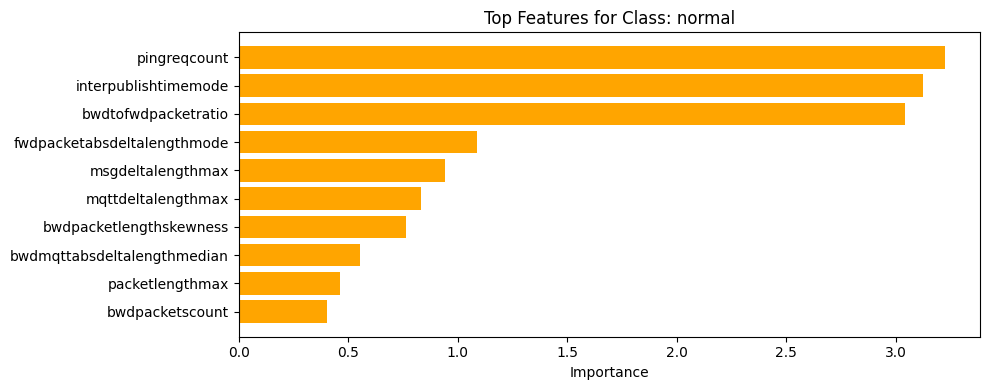

In [7]:
import matplotlib.pyplot as plt
feature_dict = {
    'normal': {
        'pingreqcount': 3.22286,
        'interpublishtimemode': 3.12408,
        'bwdtofwdpacketratio': 3.04233,
        'fwdpacketabsdeltalengthmode': 1.09026,
        'msgdeltalengthmax': 0.94114,
        'mqttdeltalengthmax': 0.83149,
        'bwdpacketlengthskewness': 0.76503,
        'bwdmqttabsdeltalengthmedian': 0.55364,
        'packetlengthmax': 0.46449,
        'bwdpacketscount': 0.40361,
    },}
# Plot bar charts for each class
for class_name, feature_dict_class in feature_dict.items():
    features = list(feature_dict_class.keys())
    importances = list(feature_dict_class.values())

    plt.figure(figsize=(10, 4))
    plt.barh(features[::-1], importances[::-1], color='orange')  # reverse for top-to-bottom, use a valid color
    plt.xlabel("Importance")
    plt.title(f"Top Features for Class: {class_name}")
    plt.tight_layout()
    plt.show()

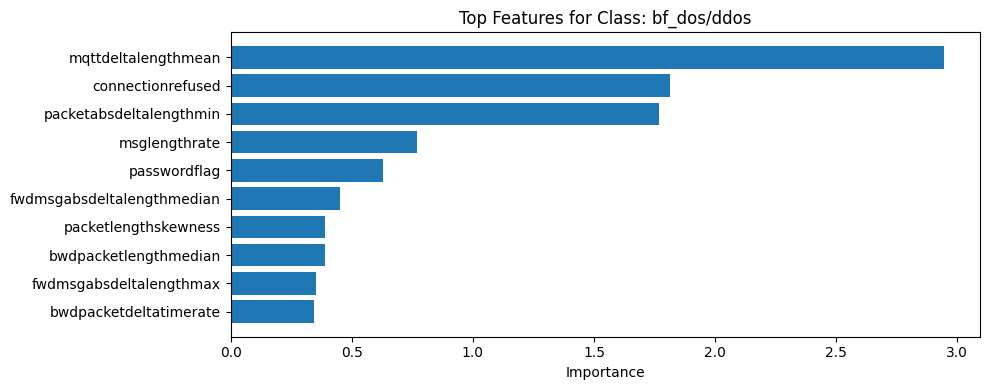

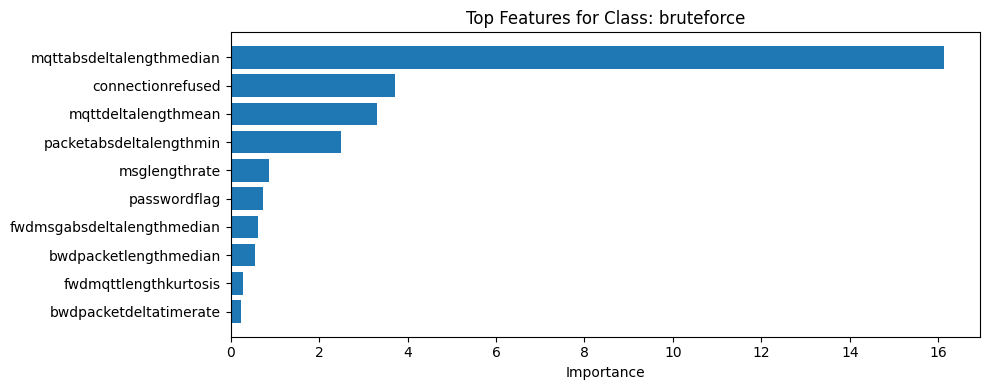

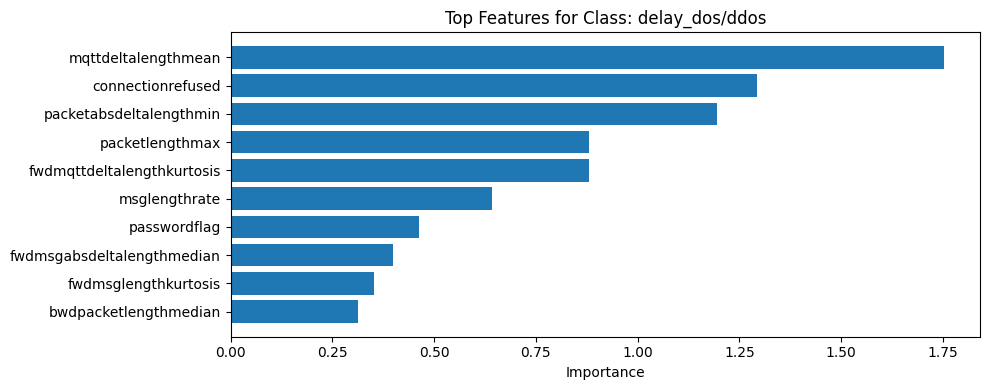

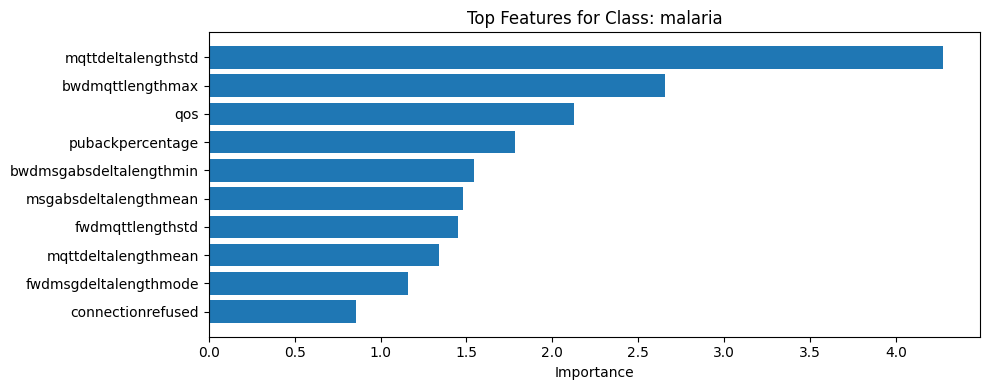

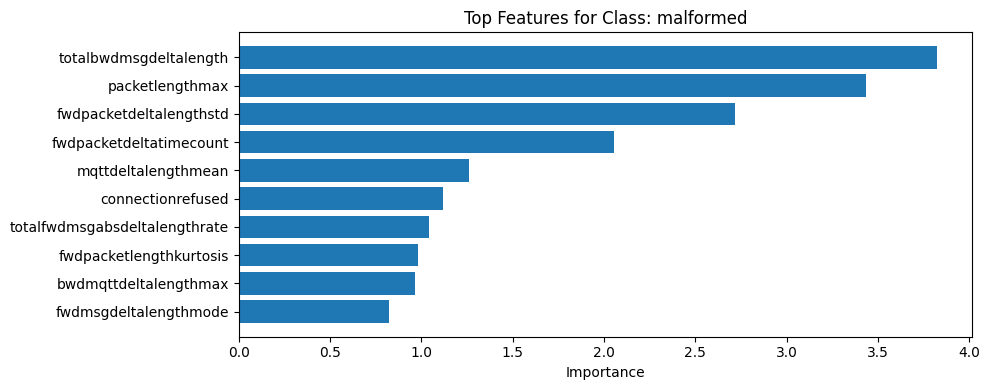

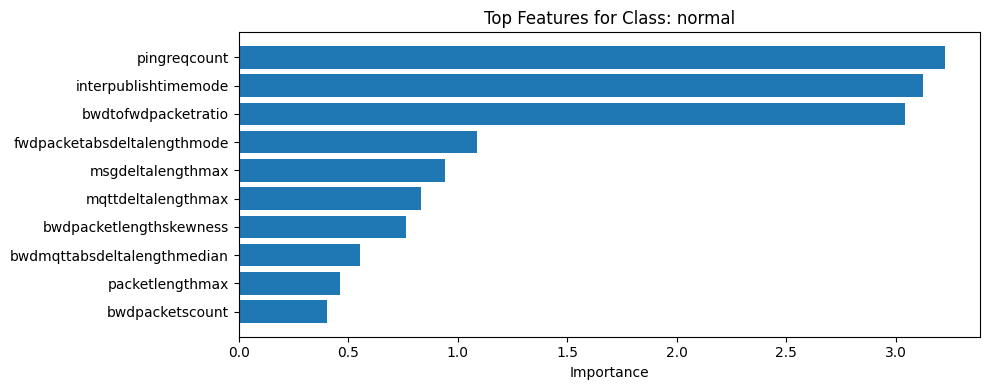

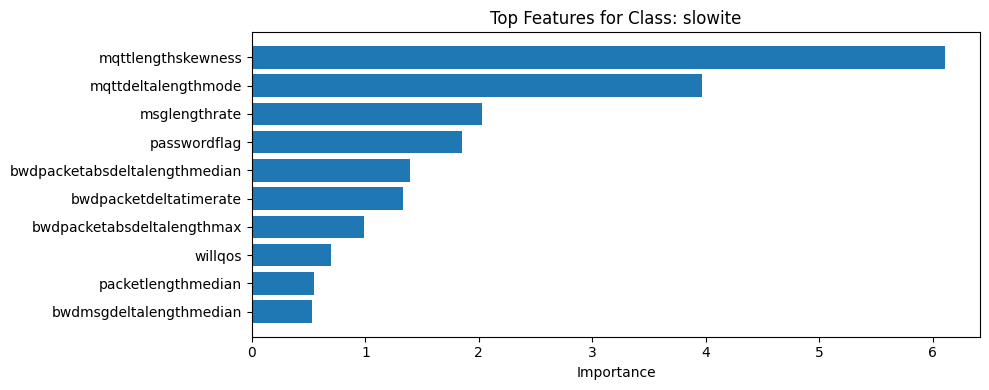

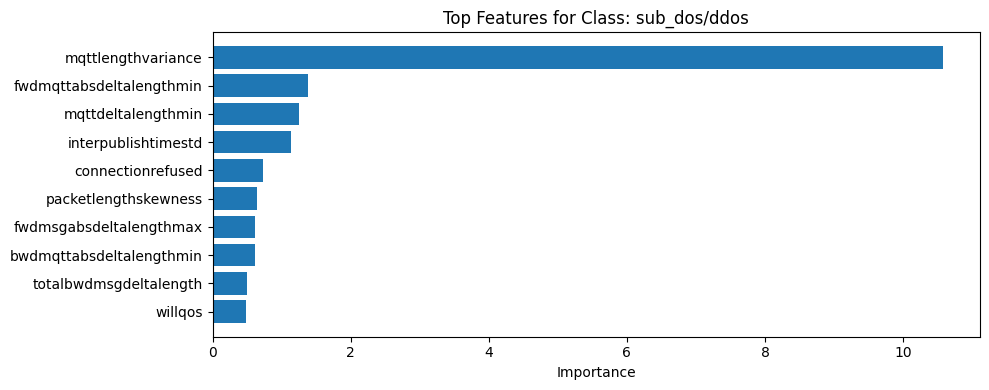

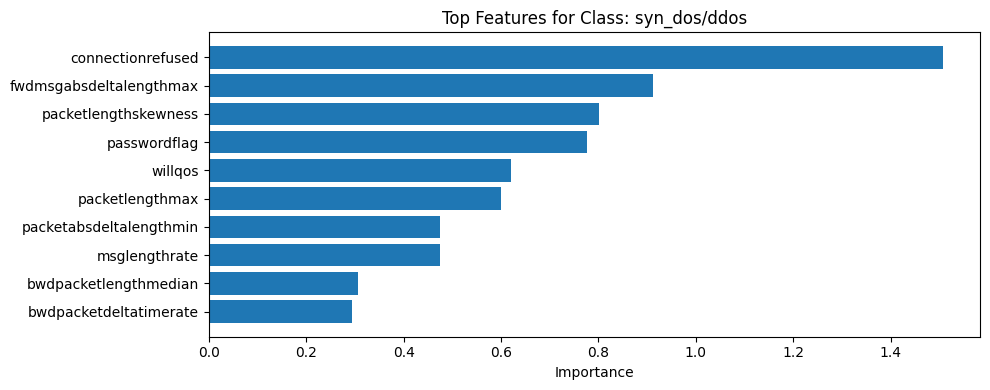

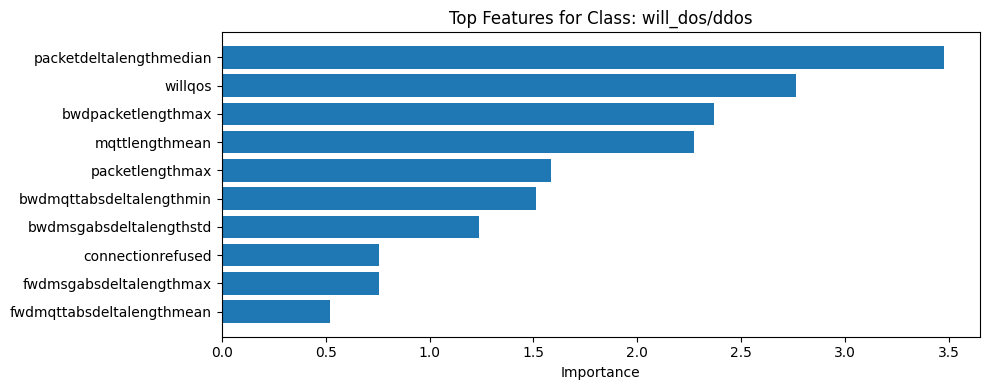

In [1]:
import matplotlib.pyplot as plt

# Replace this with your actual data if needed
feature_dict = {
    'bf_dos/ddos': {
        'mqttdeltalengthmean': 2.94612,
        'connectionrefused': 1.81558,
        'packetabsdeltalengthmin': 1.76766,
        'msglengthrate': 0.77045,
        'passwordflag': 0.63105,
        'fwdmsgabsdeltalengthmedian': 0.45217,
        'packetlengthskewness': 0.39048,
        'bwdpacketlengthmedian': 0.39034,
        'fwdmsgabsdeltalengthmax': 0.35320,
        'bwdpacketdeltatimerate': 0.34613,
    },
    'bruteforce': {
        'mqttabsdeltalengthmedian': 16.13763,
        'connectionrefused': 3.71466,
        'mqttdeltalengthmean': 3.31613,
        'packetabsdeltalengthmin': 2.49276,
        'msglengthrate': 0.86514,
        'passwordflag': 0.73411,
        'fwdmsgabsdeltalengthmedian': 0.61472,
        'bwdpacketlengthmedian': 0.54152,
        'fwdmqttlengthkurtosis': 0.27631,
        'bwdpacketdeltatimerate': 0.23233,
    },
    'delay_dos/ddos': {
        'mqttdeltalengthmean': 1.75333,
        'connectionrefused': 1.29366,
        'packetabsdeltalengthmin': 1.19479,
        'packetlengthmax': 0.88075,
        'fwdmqttdeltalengthkurtosis': 0.87931,
        'msglengthrate': 0.64208,
        'passwordflag': 0.46302,
        'fwdmsgabsdeltalengthmedian': 0.39965,
        'fwdmsglengthkurtosis': 0.35227,
        'bwdpacketlengthmedian': 0.31254,
    },
    'malaria': {
        'mqttdeltalengthstd': 4.27531,
        'bwdmqttlengthmax': 2.65390,
        'qos': 2.12547,
        'pubackpercentage': 1.78047,
        'bwdmsgabsdeltalengthmin': 1.54222,
        'msgabsdeltalengthmean': 1.47838,
        'fwdmqttlengthstd': 1.45267,
        'mqttdeltalengthmean': 1.34116,
        'fwdmsgdeltalengthmode': 1.16263,
        'connectionrefused': 0.85483,
    },
    'malformed': {
        'totalbwdmsgdeltalength': 3.82343,
        'packetlengthmax': 3.43436,
        'fwdpacketdeltalengthstd': 2.71475,
        'fwdpacketdeltatimecount': 2.05505,
        'mqttdeltalengthmean': 1.26216,
        'connectionrefused': 1.11850,
        'totalfwdmsgabsdeltalengthrate': 1.04306,
        'fwdpacketlengthkurtosis': 0.98294,
        'bwdmqttdeltalengthmax': 0.96669,
        'fwdmsgdeltalengthmode': 0.82373,
    },
    'normal': {
        'pingreqcount': 3.22286,
        'interpublishtimemode': 3.12408,
        'bwdtofwdpacketratio': 3.04233,
        'fwdpacketabsdeltalengthmode': 1.09026,
        'msgdeltalengthmax': 0.94114,
        'mqttdeltalengthmax': 0.83149,
        'bwdpacketlengthskewness': 0.76503,
        'bwdmqttabsdeltalengthmedian': 0.55364,
        'packetlengthmax': 0.46449,
        'bwdpacketscount': 0.40361,
    },
    'slowite': {
        'mqttlengthskewness': 6.11227,
        'mqttdeltalengthmode': 3.96869,
        'msglengthrate': 2.02779,
        'passwordflag': 1.85554,
        'bwdpacketabsdeltalengthmedian': 1.38911,
        'bwdpacketdeltatimerate': 1.33222,
        'bwdpacketabsdeltalengthmax': 0.98910,
        'willqos': 0.69629,
        'packetlengthmedian': 0.54430,
        'bwdmsgdeltalengthmedian': 0.52962,
    },
    'sub_dos/ddos': {
        'mqttlengthvariance': 10.58514,
        'fwdmqttabsdeltalengthmin': 1.37941,
        'mqttdeltalengthmin': 1.25429,
        'interpublishtimestd': 1.12838,
        'connectionrefused': 0.72349,
        'packetlengthskewness': 0.63743,
        'fwdmsgabsdeltalengthmax': 0.60988,
        'bwdmqttabsdeltalengthmin': 0.60802,
        'totalbwdmsgdeltalength': 0.49583,
        'willqos': 0.47846,
    },
    'syn_dos/ddos': {
        'connectionrefused': 1.50800,
        'fwdmsgabsdeltalengthmax': 0.91233,
        'packetlengthskewness': 0.80189,
        'passwordflag': 0.77595,
        'willqos': 0.61945,
        'packetlengthmax': 0.60012,
        'packetabsdeltalengthmin': 0.47545,
        'msglengthrate': 0.47527,
        'bwdpacketlengthmedian': 0.30686,
        'bwdpacketdeltatimerate': 0.29395,
    },
    'will_dos/ddos': {
        'packetdeltalengthmedian': 3.47481,
        'willqos': 2.76252,
        'bwdpacketlengthmax': 2.37038,
        'mqttlengthmean': 2.27011,
        'packetlengthmax': 1.58231,
        'bwdmqttabsdeltalengthmin': 1.51410,
        'bwdmsgabsdeltalengthstd': 1.23655,
        'connectionrefused': 0.75770,
        'fwdmsgabsdeltalengthmax': 0.75456,
        'fwdmqttabsdeltalengthmean': 0.52321,
    }
}

# Plot bar charts for each class
for class_name, feature_dict_class in feature_dict.items():
    features = list(feature_dict_class.keys())
    importances = list(feature_dict_class.values())

    plt.figure(figsize=(10, 4))
    plt.barh(features[::-1], importances[::-1])  # reverse for top-to-bottom
    plt.xlabel("Importance")
    plt.title(f"Top Features for Class: {class_name}")
    plt.tight_layout()
    plt.show()


In [65]:
# Define the base path for datasets
base_path = "C:/Users/bcccu/Desktop/Dataset/MQTT-IOT-IDS2020/MQTT-IOT-IDS2020"
mqtt_bruteforce = pd.read_csv(os.path.join(base_path, 'mqtt_bruteforce_batch_1.csv'))
mqtt_bruteforce['label'] = 'mqtt_bruteforce'

# Combine all datasets
df_ids2020 = pd.concat([mqtt_bruteforce], ignore_index=True)

# Print dataset size
print("Dataset loaded successfully! Shape:", df_ids2020.shape)
print(df_ids2020['label'].value_counts())
df_ids2020.columns = df_ids2020.columns.str.lower().str.replace(' ', '_')
categorical_features = df_ids2020.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:", categorical_features)

# Assuming X is your DataFrame
# Check if 'fwdtobwdpacketratio' is in the list of object columns
tt = df_ids2020.select_dtypes(include=['object']).columns
print(tt)

if 'fwdtobwdpacketratio' in tt:
	# Replace 'zero-bwd-packets' with -1
	df_ids2020['fwdtobwdpacketratio'] = df_ids2020['fwdtobwdpacketratio'].replace('zero-bwd-packets', -1).astype('Float64')
	
	# Print unique values after replacement
	print(df_ids2020['fwdtobwdpacketratio'].unique())
else:
	print("'fwdtobwdpacketratio' is not an object column")


if 'willmsglen' in tt:
	print(df_ids2020['willmsglen'].unique())
	df_ids2020['willmsglen'] = df_ids2020['willmsglen'].replace('EMPTY', -1).astype('Float64')
else:
	print("'willmsglen' is not an object column")
	
print(df_ids2020['willmsglen'].unique())    



if 'willtopiclen' in tt:
	print(df_ids2020['willtopiclen'].unique())
	df_ids2020['willtopiclen'] = df_ids2020['willtopiclen'].replace('EMPTY', -1).astype(int)
else:
	print("'willtopiclen' is not an object column")
	
print(df_ids2020['willtopiclen'].unique())    



if 'protocolname' in df_ids2020.columns:
	print(df_ids2020['protocolname'].unique())
	df_ids2020['protocolname'] = df_ids2020['protocolname'].replace(np.nan , 'MQTT').astype(str)
else:
	print("'protocolname' column does not exist in the dataframe")
	
print(df_ids2020['protocolname'].unique() if 'protocolname' in df_ids2020.columns else "Column 'protocolname' does not exist")    



# Drop only the columns that exist in the dataframe
columns_to_drop = ['protocolnamelength','passwordlen','usernamelen','flowid', 'tcpid', 'srcip', 'dstip',  'srcport', 'dstport', 'connect_id', 'clientid', 'topic', 'starttime', 'endtime', 'username', 'password', 'protocolname', 'connect_id']
df_ids2020 = df_ids2020.drop(columns=[col for col in columns_to_drop if col in df_ids2020.columns])
print("Columns dropped successfully! Shape:", df_ids2020.shape)

# Extract features and labels
X_ids2020 = df_ids2020.drop(columns=['label'])
y_ids2020 = df_ids2020['label']
print(y_ids2020.value_counts())



# Apply the same label encoding from training
for col in X_ids2020.select_dtypes(include=['object']).columns:
    X_ids2020[col] = label_encoder.transform(X_ids2020[col].astype(str))





C:\Users\bcccu\AppData\Local\Temp\ipykernel_38532\2918024284.py:3: DtypeWarning: Columns (362) have mixed types. Specify dtype option on import or set low_memory=False.
  mqtt_bruteforce = pd.read_csv(os.path.join(base_path, 'mqtt_bruteforce_batch_1.csv'))


Dataset loaded successfully! Shape: (249999, 404)
label
mqtt_bruteforce    249999
Name: count, dtype: int64
Categorical features: ['flowid', 'tcpid', 'srcip', 'dstip', 'clientid', 'topic', 'starttime', 'endtime', 'username', 'password', 'fwdtobwdpacketratio', 'willmsglen', 'willtopiclen', 'protocolname', 'label']
Index(['flowid', 'tcpid', 'srcip', 'dstip', 'clientid', 'topic', 'starttime',
       'endtime', 'username', 'password', 'fwdtobwdpacketratio', 'willmsglen',
       'willtopiclen', 'protocolname', 'label'],
      dtype='object')
<FloatingArray>
[1.0, 6.0, 3.0, -1.0, 5.0]
Length: 5, dtype: Float64
['EMPTY' '0']
<FloatingArray>
[-1.0, 0.0]
Length: 2, dtype: Float64
['EMPTY' '0']
[-1  0]
['MQTT 3.1.1 or later' nan]
['MQTT 3.1.1 or later' 'MQTT']
Columns dropped successfully! Shape: (249999, 387)
label
mqtt_bruteforce    249999
Name: count, dtype: int64


In [66]:
# Handle missing values
for col in X_ids2020.columns:
    if X_ids2020[col].isnull().sum() > 0:
        if X_ids2020[col].dtype == 'object':  # Categorical
            X_ids2020[col] = X_ids2020[col].fillna(X_ids2020[col].mode()[0])  # Assign explicitly

        else:  # Numerical
            X_ids2020[col] = X_ids2020[col].fillna(X_ids2020[col].median())  # Assign explicitly
            

print("Missing values handled successfully!")

# Convert to Float32 for PyTorch compatibility
X_ids2020 = X_ids2020.astype(np.float32)

Missing values handled successfully!


In [67]:
# Get class probabilities for the test set (or new data with unseen label)
test_proba = tabnet_model2.predict_proba(X_ids2020.values)  # Replace X_test with unseen data if needed
print("Class Probabilities for Test Set:")
print(test_proba)


Class Probabilities for Test Set:
[[8.3781189e-01 3.7332261e-03 1.5837610e-01 ... 3.9128983e-05
  3.9301485e-06 1.1230909e-05]
 [8.3028907e-01 1.6576326e-03 1.6799065e-01 ... 2.6064805e-05
  3.6377585e-06 1.1837954e-05]
 [8.0379885e-01 2.8844015e-04 1.9586536e-01 ... 1.2564657e-05
  3.2120902e-06 1.3776644e-05]
 ...
 [8.2373095e-01 9.8709553e-04 1.7522629e-01 ... 2.0472920e-05
  3.4793661e-06 1.2326039e-05]
 [8.2095671e-01 8.0951210e-04 1.7817990e-01 ... 1.8774570e-05
  3.4273692e-06 1.2529326e-05]
 [5.8074913e-04 5.1169794e-15 1.4355344e-02 ... 9.8663208e-04
  9.7625738e-01 7.5380346e-03]]


In [68]:
import numpy as np
import pandas as pd



# Ensure test_proba has the correct shape
if test_proba.ndim == 2 and test_proba.shape[1] == len(class_names):
    # Set a threshold for confidence
    confidence_threshold = 0.7
    max_prob = np.max(test_proba, axis=1)
    predicted_class = np.argmax(test_proba, axis=1)

    # Convert predictions to labels
    predicted_labels = [class_names[pred] for pred in predicted_class]

    # Identify low-confidence (unseen) samples
    is_unseen = max_prob < confidence_threshold

    # Create a DataFrame for analysis
    df_results = pd.DataFrame({
        "Predicted Class": predicted_labels,
        "Max Probability": max_prob,
        "Unseen": is_unseen
    })

    # Count how many times each class is marked as "unseen"
    unseen_counts = df_results[df_results["Unseen"]].groupby("Predicted Class").size()

    # Convert to percentage
    unseen_percentage = (unseen_counts / df_results["Predicted Class"].value_counts()) * 100

    # Display results
    print("\nUnseen Label Distribution:")
    print(unseen_percentage.fillna(0).sort_values(ascending=False))

else:
    print("Error: test_proba does not have the expected shape.")





Unseen Label Distribution:
Predicted Class
delay_dos/ddos    100.000000
syn_dos/ddos        7.142857
bruteforce          6.961078
bf_dos/ddos         0.064350
will_dos/ddos       0.000000
dtype: float64


In [69]:
# Get the predicted probabilities for a test sample

# Ensure test_proba has the correct shape
if test_proba.ndim == 2 and test_proba.shape[1] == len(class_names):
    # Set a threshold for how confident the model has to be
    confidence_threshold = 0.7  # e.g., if the highest probability is below 0.7, it's "unseen"
    max_prob = np.max(test_proba, axis=1)

    if np.any(max_prob < confidence_threshold):
        print("This sample may be an unseen label based on low confidence.")
        print("max_prob:", max_prob)
    else:
        predicted_class = np.argmax(test_proba, axis=1)
        for i, prob in enumerate(max_prob):
            print(f"Sample {i} is classified as '{class_names[predicted_class[i]]}' with probability {prob:.2f}")
else:
    print("Error: test_proba does not have the expected shape.")


This sample may be an unseen label based on low confidence.
max_prob: [0.8378119  0.83028907 0.80379885 ... 0.82373095 0.8209567  0.9762574 ]


In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean probability per class across ALL test samples
mean_test_proba = np.mean(test_proba, axis=0)

# Find the most confident class even among uncertain predictions
predicted_label = class_names[np.argmax(mean_test_proba)]
highest_prob = np.max(mean_test_proba)

print(f"Across all test samples, the model is most confident in '{predicted_label}' with an average probability of {highest_prob:.2f}")

# # Plot mean probability distribution
# plt.figure(figsize=(10, 5))
# plt.bar(class_names, mean_test_proba, color='lightcoral')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel("Mean Probability")
# plt.xlabel("Class Labels")
# plt.title(f"Mean Probability Distribution Across All Test Samples\n(Predicted: {predicted_label}, Confidence: {highest_prob:.2f})")
# plt.ylim(0, 1)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


Across all test samples, the model is most confident in 'bf_dos/ddos' with an average probability of 0.80


In [72]:
import numpy as np

# Compute the mean probability for each class across all test samples
mean_test_proba = np.mean(test_proba, axis=0)  # Mean probability per class
std_test_proba = np.std(test_proba, axis=0)    # Standard deviation (to see variability)

# Create a confidence report for each label
confidence_report = {class_names[i]: {"Mean Probability": mean_test_proba[i], "Std Dev": std_test_proba[i]} for i in range(len(class_names))}

# Display results
print("\nConfidence Levels for Each Label:")
for label, stats in confidence_report.items():
    print(f"{label}: Mean Probability = {stats['Mean Probability']:.4f}, Std Dev = {stats['Std Dev']:.4f}")



Confidence Levels for Each Label:
bf_dos/ddos: Mean Probability = 0.8014, Std Dev = 0.0595
bruteforce: Mean Probability = 0.0061, Std Dev = 0.0698
delay_dos/ddos: Mean Probability = 0.1925, Std Dev = 0.0246
malaria: Mean Probability = 0.0000, Std Dev = 0.0000
malformed: Mean Probability = 0.0000, Std Dev = 0.0000
normal: Mean Probability = 0.0000, Std Dev = 0.0001
slowite: Mean Probability = 0.0000, Std Dev = 0.0000
sub_dos/ddos: Mean Probability = 0.0000, Std Dev = 0.0006
syn_dos/ddos: Mean Probability = 0.0001, Std Dev = 0.0073
will_dos/ddos: Mean Probability = 0.0000, Std Dev = 0.0044


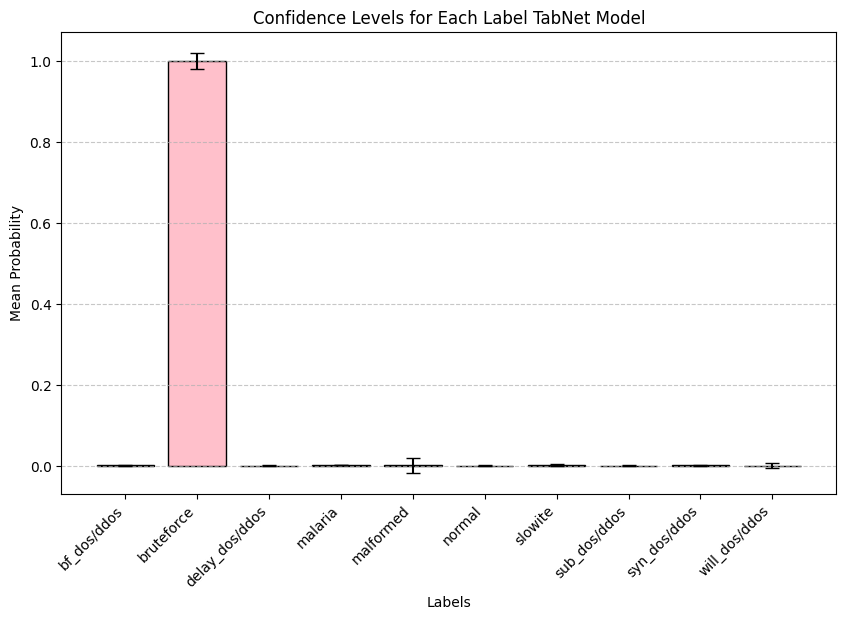

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = [
    "bf_dos/ddos", "bruteforce", "delay_dos/ddos", "malaria", "malformed",
    "normal", "slowite", "sub_dos/ddos", "syn_dos/ddos", "will_dos/ddos"
]

mean_probs = [0.0003, 0.9995, 0.0000, 0.0008, 0.0002, 0.0000, 0.0004, 0.0000, 0.0001, 0.0000]
std_devs = [0.0004, 0.0201, 0.0013, 0.0001, 0.0177, 0.0009, 0.0026, 0.0009, 0.0023, 0.0059]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, mean_probs, yerr=std_devs, capsize=5, color='pink', edgecolor='black')

# Labels and title
ax.set_xlabel("Labels")
ax.set_ylabel("Mean Probability")
ax.set_title("Confidence Levels for Each Label TabNet Model") 
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean probability for each class across all test samples
mean_test_proba = np.mean(test_proba, axis=0)  # Mean probability per class
std_test_proba = np.std(test_proba, axis=0)    # Standard deviation per class

# Plot the mean probability with error bars (standard deviation)
plt.figure(figsize=(10, 5))
plt.bar(class_names, mean_test_proba, yerr=std_test_proba, capsize=5, color='lightcoral', alpha=0.7)

# Labels and title
plt.xlabel("Class Labels")
plt.ylabel("Mean Probability")
plt.title("Confidence Levels for Each Label (Mean Probability ± Std Dev)")
plt.ylim(0, 1)  # Probabilities are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


: 

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities for all unseen samples

# Ensure test_proba has the correct shape
if test_proba.ndim == 2 and test_proba.shape[1] == len(class_names):
    mean_proba = np.mean(test_proba, axis=0)  # Compute mean probabilities for each class

    # Get the class with the highest mean probability
    predicted_label = class_names[np.argmax(mean_proba)]
    highest_prob = np.max(mean_proba)

    print(f"Overall, the unseen samples are most likely '{predicted_label}' with an average probability of {highest_prob:.2f}")

    # Plot mean probability distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, mean_proba, color='lightcoral')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Mean Probability")
    plt.xlabel("Class Labels")
    plt.title(f"Mean Probability Distribution Across All Unseen Samples\n(Predicted: {predicted_label}, Confidence: {highest_prob:.2f})")
    plt.ylim(0, 1)  # Probabilities are between 0 and 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Error: test_proba does not have the expected shape.")


: 